---

# Computational Finance and Financial Management

## Analysis, replication and forecasting of the German TecDAX Stock Index

 By **Merlin Bartel** and **Max Veltwisch**

---

### Introduction

Trying to predict the stock market is an enticing prospect to us, not so much as a desire for material gain, but for the challenge. Already in 1965 the Economist and Nobel Price winner Paul Samuelson postulated in his influencial paper "Properly Anticipated Prices Fluctuate Randomly" that returns of the past have no prediction power for future returns. He concluded that market prices could be considered a Martingale. This in turn implies that the analysis and knownledge about the historical price development of an underlying is of no use for future price predictions. Nevertheless by looking at the daily up and downs of the market, we imagine there must be patterns we can model to beat all odds. Our analysis follows 4 sections:

1. **Exploratory analysis**: Analysing the historical price data of the TecDAX Index over time.
2. **Replication**: Applying a Deep-Learning method to predict the weights of the stocks contained in the TecDAX Index.
3. **Additive Model Forecasting**: Applying the Facebook Prophet model on time-series price data of the TecDAX Index in order to forcast future price movements.
4.  **Recurrent Neural Network Forecasting**: Applying a Long Short-Term Memory (LSTM) model on time-series price data of the TecDAX Index in order to forecast future price movements.

Section 1 serves the goal to better understand the general structure and charateristics of the historical price development of the TecDAX Index. Section 2 differs from the following sections by trying to estimate the weights of the stocks contained in the TecDAX Index in a way that replication becomes as precise as possible. Section 3 and 4 make use of different model approaches with the goal of recognising patterns in the historical price data of the TecDAX Index and using them to forecast future Index prices.


Before we start with our research we load the required python packages into our environment.

In [22]:
#loading required packages
import math
import pylab
import numpy as np
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
from datetime import datetime

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.losses import mean_squared_error
from keras import optimizers

import statistics
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import special, optimize

from fbprophet import Prophet

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

---
## 1. Exploratory Analysis
---
### Data

For this report we are looking at price data of the TecDAX Index from 01.01.2007 - 01.06.2019.  In section 2 we use the price data of all stocks contained in the TexDAX Index from 01.07.2015 - 31.05.2019. The variable of interest in all sections is the adjusted closing price. The following two tables show the structure of both datasets. The source of the datasets is: finance.yahoo.com in combination with onvista.com


In [23]:
# importing TecDAX Index price data
TecDAX = pd.read_csv("TECDAX.csv", index_col=0, parse_dates=True, squeeze=True)

# extracting adjusted close prices (variable of interest)
TecDAX_close = TecDAX["Adj Close"]

# showing the first 5 observations
TecDAX.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-01-02,749.690002,759.510010,749.309998,759.070007,759.070007,126187800
2007-01-03,761.119995,778.429993,761.119995,777.400024,777.400024,0
2007-01-04,772.880005,772.880005,763.270020,765.960022,765.960022,0
2007-01-05,764.059998,765.049988,759.840027,763.309998,763.309998,135319300
2007-01-08,763.150024,767.419983,762.119995,764.450012,764.450012,0


In [24]:
# importing stock data contained in TecDAX Index
TecDAX_stocks = pd.read_csv("Alltogether.csv", encoding='latin-1')
TecDAX_stocks["Date"] = pd.to_datetime(TecDAX_stocks["Date"])

# setting "Date" as index
TecDAX_stocks.set_index("Date", inplace=True)

# showing the first 5 observations
TecDAX_stocks.head()

,TecDAX,1&1 Drillisch,Aixtron,Aumann,Adva,Bechtle,Cancom,Carl Zeiss Meditec,CompuGroup,Dialog Semiconductor,...,SLM,SMA,Software,Stratec,Süss,Telefonica,Telekom,United Internet,Wirecard,Xing
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-07,1672.390015,35.488747,6.138,0.0,8.735,32.312878,15.390124,23.140257,30.854900,50.439999,...,0.0,19.845375,22.504152,46.892555,0.0,3.897666,0.0,38.481964,35.000416,149.166504
2015-02-07,1658.420044,35.128826,6.186,0.0,8.510,32.572384,15.279471,23.116240,30.434217,49.540001,...,0.0,20.977575,22.481371,46.043972,0.0,3.854635,0.0,37.891987,35.253502,144.268646
2015-03-07,1656.959961,35.119827,6.127,0.0,8.774,32.317509,15.206487,23.250748,30.743683,49.669998,...,0.0,20.438433,22.196175,46.775349,0.0,3.830477,0.0,37.915779,35.551250,143.056290
2015-06-07,1651.089966,34.354984,6.089,0.0,8.700,32.901394,15.133503,23.130648,30.980619,50.200001,...,0.0,20.193369,21.840816,46.039280,0.0,3.769329,0.0,37.663612,35.169140,142.037933
2015-07-07,1625.170044,32.789299,5.983,0.0,8.590,32.794811,16.021078,22.909670,31.498013,48.735001,...,0.0,19.825769,22.082279,46.976948,0.0,3.656845,0.0,37.187820,34.479359,138.206909


### Visualising the data
Visualizing our time-series data enables us to make inferences about important components, such as trend and seasonality and correlation. By plotting the price development of the TecDAX Index over time, we can easily see that the Index has instances of both positive and negative trend, with the later one dominating in the long-run. We also see the price reaction of the Index to the fincial crisis of 2008 and the increasing insecurity at the beginning of 2016. 

We can further compute the daily returns of the prices and verify Paul Samuelsons statement about the unpredictability of stock returns. Just by plotting the daily returns we can already guess that making acurate predictions about future returns will be a hard, if not a outrageous task. Instead of following recurring patterns the returns seem more like white noise fluctuating around a center somewhere at 0. To further confirm this first impression we make use of the autocorrelation function (ACF). This functions helps us understand the correlation component of different returns at different time lags. Lag refers to the time difference between one observation and a previous observation in a dataset. By plotting the ACF we indeed see, that there is almost no statistically significant correlation between todays returns and those in the future. 

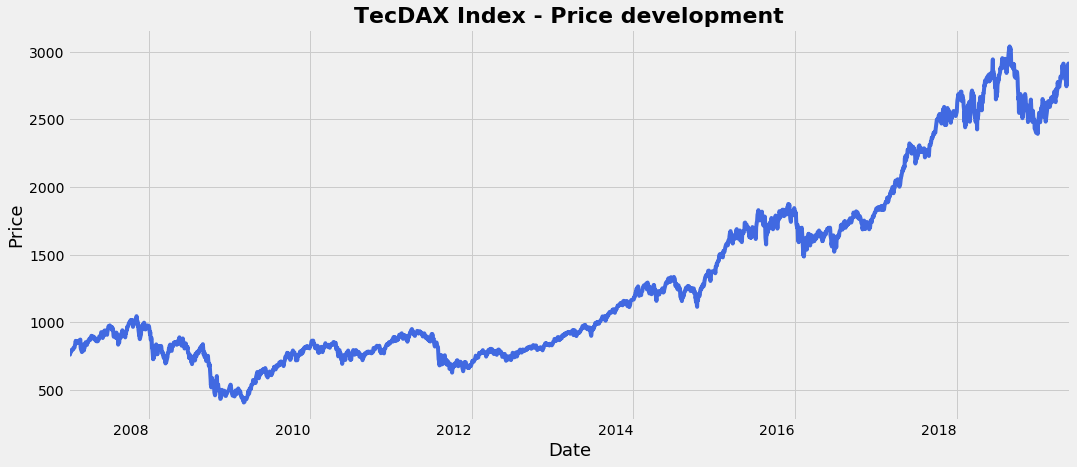

In [25]:
# visualising historical Index price movement
plt.style.use('fivethirtyeight')

TecDAX_close.plot(figsize=(16,8), color="royalblue")
plt.xlabel("Date",fontsize=18,color="black")
plt.ylabel("Price",fontsize=18,color="black")
plt.title("TecDAX Index - Price development",fontweight="bold",fontsize=22)
plt.xticks(rotation=0)

plt.show()

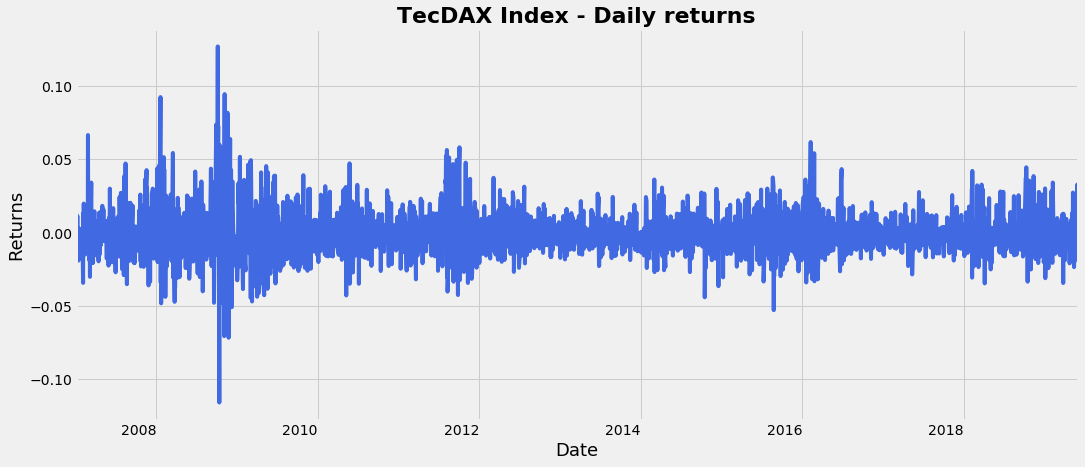

In [26]:
# calculating the daily Index returns
daily_returns = TecDAX_close.shift(1) / TecDAX_close - 1

# visualising the daily Index returns
daily_returns.plot(figsize=(16,8), color="royalblue")
plt.xlabel("Date",fontsize=18,color="black")
plt.ylabel("Returns",fontsize=18,color="black")
plt.title("TecDAX Index - Daily returns", fontweight="bold",fontsize=22)
plt.xticks(rotation=0)

plt.show()

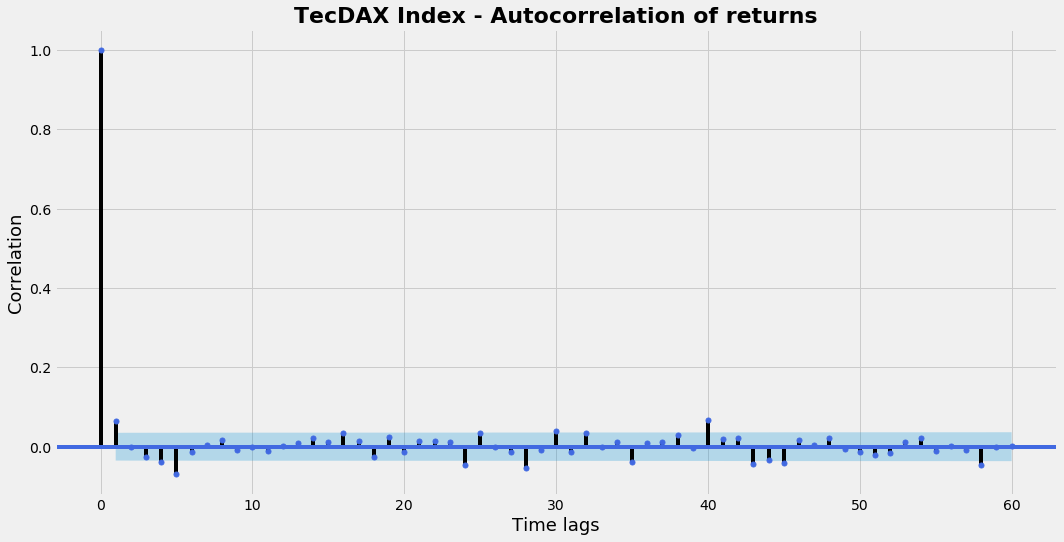

In [27]:
#visualising the autocorrelation of Index returns
plt.rcParams["figure.figsize"] = (16,8)
plot_acf(daily_returns[1:], lags=60, color="royalblue")
plt.title("TecDAX Index - Autocorrelation of returns", fontweight="bold",fontsize=22)
plt.xlabel("Time lags",fontsize=18,color="black")
plt.ylabel("Correlation",fontsize=18,color="black")

plt.show()

---
## 2. Replication 
---

The first model we create is a very lean model, which sets a nice starting point into the world of Deep-Learning. The model is trained on regressing the TecDAX Index on daily historical stock price data.

We use price data of the TecDAX Index reaching from the 01.07.2015 to 01.06.2019 to attain maximum data quality.
As you will see, the optimal lean model does not have Hidden Layers and only one neuron in the Input Layer and is not affected by Overfitting. 
As so, it perfectly shows the minimum criteria for single neurons to be useful. To increase the prediction power of this model, it is indispensable to iterate the model over several weeks and to run tests with different Hyperparameters in order to find the optimal setup. The predictions and metrics of the validationset portraying the missing Overfitting are displayed below.

In [28]:
# importing and indexing stock and index data
TecDAX_stocks = pd.read_csv("Alltogether.csv", encoding='latin-1') 
TecDAX_stocks["Date"] = pd.to_datetime(TecDAX_stocks["Date"])
TecDAX_stocks.set_index("Date", inplace=True)  

# separating TecDAX Index data from stock data
y = TecDAX_stocks["TecDAX"]
y = y.values.reshape(len(y),1)
x = TecDAX_stocks.iloc [0:,1:]
x = x.values.reshape(len(y),41)

# defining prediction horizon
test_size = 27
train_size  = len(y) - test_size

# splitting the data into training and test set
y_train, y_test = y[0:train_size], y[train_size:len(y)]
x_train, x_test = x[0:train_size,:], x[train_size:len(y),:]

# extracting validation set from training set
train_size2  = int(train_size * 0.7)

# creating buffer-variable to combine TecDAX data with underlying stock data
buff = np.append(y_train, x_train, axis =1)

# randomizing sample and splitting TecDAX data from stock data again
np.random.shuffle(buff)
y_buff = buff[:,0]
x_buff = buff[:,1:]
np.reshape(x_buff, (len(x_buff),41))
np.reshape(y_buff, (len(x_buff),1))

# rearranging original Data
y_train, y_valid = y_buff[0:train_size2], y_buff[train_size2:train_size]
x_train, x_valid = x_buff[0:train_size2,:], x_buff[train_size2:train_size,:]

In [35]:
# building the neural network
def index_model():
    model = Sequential()
    
    # input layer
    model.add(Dense(1,activation='linear',input_dim=x_train.shape[1])) #the activation function can be linear, since the network consists of only 1 neuron
    
    # output layer
    model.add(Dense(1)) # Scalar Regression -> No Actication Function
    
    # compiling the model, defining optimizer and loss function
    model.compile(optimizer='Adam',loss='mean_absolute_error')
    return model

In [36]:
# !! fitting the model can take significant amount of time and computation power !!

model = index_model()

# traininging the neural network, including validation set to check if overfitting occurs
history = model.fit(x_train, y_train, epochs=10000, validation_data=(x_valid, y_valid))

# getting the performance by using the validaiton set 
Error = model.evaluate(x_train, y_train)
print("Error for the test set: ", Error)

Train on 675 samples, validate on 290 samples
Epoch 1/10000
675/675 [==============================] - 2s 2ms/step - loss: 2188.7721 - val_loss: 2171.3162
Epoch 2/10000
675/675 [==============================] - 0s 62us/step - loss: 2172.2453 - val_loss: 2155.0869
Epoch 3/10000
675/675 [==============================] - 0s 60us/step - loss: 2155.4058 - val_loss: 2137.0749
Epoch 4/10000
675/675 [==============================] - 0s 65us/step - loss: 2135.9076 - val_loss: 2116.1354
Epoch 5/10000
675/675 [==============================] - 0s 71us/step - loss: 2113.3837 - val_loss: 2091.9602
Epoch 6/10000
675/675 [==============================] - 0s 64us/step - loss: 2087.6462 - val_loss: 2064.5926
Epoch 7/10000
675/675 [==============================] - 0s 63us/step - loss: 2058.5542 - val_loss: 2033.9354
Epoch 8/10000
675/675 [==============================] - 0s 55us/step - loss: 2026.3393 - val_loss: 2000.2008
Epoch 9/10000
675/675 [==============================] - 0s 57us/step - los

675/675 [==============================] - 0s 57us/step - loss: 20.3708 - val_loss: 20.2934
Epoch 77/10000
675/675 [==============================] - 0s 58us/step - loss: 20.3124 - val_loss: 20.1649
Epoch 78/10000
675/675 [==============================] - 0s 53us/step - loss: 20.2485 - val_loss: 20.2139
Epoch 79/10000
675/675 [==============================] - 0s 54us/step - loss: 20.2174 - val_loss: 20.0232
Epoch 80/10000
675/675 [==============================] - 0s 52us/step - loss: 20.1421 - val_loss: 20.0463
Epoch 81/10000
675/675 [==============================] - 0s 50us/step - loss: 20.1609 - val_loss: 19.9780
Epoch 82/10000
675/675 [==============================] - 0s 57us/step - loss: 20.1017 - val_loss: 19.8873
Epoch 83/10000
675/675 [==============================] - 0s 53us/step - loss: 19.9070 - val_loss: 19.8323
Epoch 84/10000
675/675 [==============================] - 0s 50us/step - loss: 19.9809 - val_loss: 19.7667
Epoch 85/10000
675/675 [============================

675/675 [==============================] - 0s 51us/step - loss: 15.8647 - val_loss: 15.7042
Epoch 153/10000
675/675 [==============================] - 0s 54us/step - loss: 15.6369 - val_loss: 15.7556
Epoch 154/10000
675/675 [==============================] - 0s 53us/step - loss: 15.5541 - val_loss: 15.7886
Epoch 155/10000
675/675 [==============================] - 0s 51us/step - loss: 15.5742 - val_loss: 15.6996
Epoch 156/10000
675/675 [==============================] - 0s 51us/step - loss: 15.5307 - val_loss: 15.6395
Epoch 157/10000
675/675 [==============================] - 0s 51us/step - loss: 15.4297 - val_loss: 15.8755
Epoch 158/10000
675/675 [==============================] - 0s 50us/step - loss: 15.5932 - val_loss: 15.5485
Epoch 159/10000
675/675 [==============================] - 0s 50us/step - loss: 15.3753 - val_loss: 15.5762
Epoch 160/10000
675/675 [==============================] - 0s 52us/step - loss: 15.3560 - val_loss: 15.7481
Epoch 161/10000
675/675 [===================

675/675 [==============================] - 0s 53us/step - loss: 13.8048 - val_loss: 14.0387
Epoch 229/10000
675/675 [==============================] - 0s 53us/step - loss: 13.8605 - val_loss: 14.1038
Epoch 230/10000
675/675 [==============================] - 0s 51us/step - loss: 13.9259 - val_loss: 14.3478
Epoch 231/10000
675/675 [==============================] - 0s 51us/step - loss: 13.7751 - val_loss: 14.0529
Epoch 232/10000
675/675 [==============================] - 0s 50us/step - loss: 13.7035 - val_loss: 14.0773
Epoch 233/10000
675/675 [==============================] - 0s 49us/step - loss: 13.7830 - val_loss: 14.0926
Epoch 234/10000
675/675 [==============================] - 0s 50us/step - loss: 13.6025 - val_loss: 13.9530
Epoch 235/10000
675/675 [==============================] - 0s 52us/step - loss: 13.7047 - val_loss: 13.9499
Epoch 236/10000
675/675 [==============================] - 0s 50us/step - loss: 13.5770 - val_loss: 13.9234
Epoch 237/10000
675/675 [===================

675/675 [==============================] - 0s 51us/step - loss: 12.4492 - val_loss: 12.9247
Epoch 305/10000
675/675 [==============================] - 0s 56us/step - loss: 12.2701 - val_loss: 12.8770
Epoch 306/10000
675/675 [==============================] - 0s 52us/step - loss: 12.3822 - val_loss: 12.8655
Epoch 307/10000
675/675 [==============================] - 0s 49us/step - loss: 12.4409 - val_loss: 12.9642
Epoch 308/10000
675/675 [==============================] - 0s 52us/step - loss: 12.2302 - val_loss: 12.9197
Epoch 309/10000
675/675 [==============================] - 0s 51us/step - loss: 12.4975 - val_loss: 12.8945
Epoch 310/10000
675/675 [==============================] - 0s 52us/step - loss: 12.3168 - val_loss: 12.8427
Epoch 311/10000
675/675 [==============================] - 0s 50us/step - loss: 12.2008 - val_loss: 12.8022
Epoch 312/10000
675/675 [==============================] - 0s 52us/step - loss: 12.4036 - val_loss: 13.0402
Epoch 313/10000
675/675 [===================

675/675 [==============================] - 0s 55us/step - loss: 11.2255 - val_loss: 12.1137
Epoch 381/10000
675/675 [==============================] - 0s 54us/step - loss: 11.3306 - val_loss: 12.0606
Epoch 382/10000
675/675 [==============================] - 0s 51us/step - loss: 11.2886 - val_loss: 12.0884
Epoch 383/10000
675/675 [==============================] - 0s 52us/step - loss: 11.3039 - val_loss: 12.2030
Epoch 384/10000
675/675 [==============================] - 0s 51us/step - loss: 11.2040 - val_loss: 11.9689
Epoch 385/10000
675/675 [==============================] - 0s 53us/step - loss: 11.1806 - val_loss: 12.3564
Epoch 386/10000
675/675 [==============================] - 0s 51us/step - loss: 11.7955 - val_loss: 12.5921
Epoch 387/10000
675/675 [==============================] - 0s 53us/step - loss: 11.2676 - val_loss: 12.0641
Epoch 388/10000
675/675 [==============================] - 0s 53us/step - loss: 11.2464 - val_loss: 12.1512
Epoch 389/10000
675/675 [===================

675/675 [==============================] - 0s 53us/step - loss: 10.5335 - val_loss: 11.4304
Epoch 457/10000
675/675 [==============================] - 0s 54us/step - loss: 10.5602 - val_loss: 11.6608
Epoch 458/10000
675/675 [==============================] - 0s 52us/step - loss: 10.5173 - val_loss: 11.5389
Epoch 459/10000
675/675 [==============================] - 0s 49us/step - loss: 10.4514 - val_loss: 11.3734
Epoch 460/10000
675/675 [==============================] - 0s 51us/step - loss: 10.4202 - val_loss: 11.5623
Epoch 461/10000
675/675 [==============================] - 0s 49us/step - loss: 10.3509 - val_loss: 12.3188
Epoch 462/10000
675/675 [==============================] - 0s 51us/step - loss: 11.0216 - val_loss: 11.9486
Epoch 463/10000
675/675 [==============================] - 0s 53us/step - loss: 10.6664 - val_loss: 11.3679
Epoch 464/10000
675/675 [==============================] - 0s 51us/step - loss: 10.5139 - val_loss: 11.3388
Epoch 465/10000
675/675 [===================

675/675 [==============================] - 0s 53us/step - loss: 9.9770 - val_loss: 10.7797
Epoch 533/10000
675/675 [==============================] - 0s 52us/step - loss: 9.8420 - val_loss: 10.9389
Epoch 534/10000
675/675 [==============================] - 0s 52us/step - loss: 9.8117 - val_loss: 10.8523
Epoch 535/10000
675/675 [==============================] - 0s 53us/step - loss: 9.7946 - val_loss: 10.8081
Epoch 536/10000
675/675 [==============================] - 0s 53us/step - loss: 9.9140 - val_loss: 10.8051
Epoch 537/10000
675/675 [==============================] - 0s 51us/step - loss: 9.8410 - val_loss: 10.7404
Epoch 538/10000
675/675 [==============================] - 0s 53us/step - loss: 9.8391 - val_loss: 10.7461
Epoch 539/10000
675/675 [==============================] - 0s 53us/step - loss: 9.8145 - val_loss: 11.1345
Epoch 540/10000
675/675 [==============================] - 0s 51us/step - loss: 9.9073 - val_loss: 10.8543
Epoch 541/10000
675/675 [============================

675/675 [==============================] - 0s 49us/step - loss: 9.5982 - val_loss: 10.3294
Epoch 609/10000
675/675 [==============================] - 0s 51us/step - loss: 9.3306 - val_loss: 10.3064
Epoch 610/10000
675/675 [==============================] - 0s 53us/step - loss: 9.3712 - val_loss: 10.3021
Epoch 611/10000
675/675 [==============================] - 0s 51us/step - loss: 9.2680 - val_loss: 10.2905
Epoch 612/10000
675/675 [==============================] - 0s 52us/step - loss: 9.5701 - val_loss: 10.4531
Epoch 613/10000
675/675 [==============================] - 0s 51us/step - loss: 9.4434 - val_loss: 10.3376
Epoch 614/10000
675/675 [==============================] - 0s 50us/step - loss: 9.3363 - val_loss: 10.3806
Epoch 615/10000
675/675 [==============================] - 0s 52us/step - loss: 9.2640 - val_loss: 10.5127
Epoch 616/10000
675/675 [==============================] - 0s 53us/step - loss: 9.2542 - val_loss: 10.6437
Epoch 617/10000
675/675 [============================

675/675 [==============================] - 0s 51us/step - loss: 8.9051 - val_loss: 9.9636
Epoch 685/10000
675/675 [==============================] - 0s 53us/step - loss: 8.9318 - val_loss: 10.0412
Epoch 686/10000
675/675 [==============================] - 0s 51us/step - loss: 9.6781 - val_loss: 10.6309
Epoch 687/10000
675/675 [==============================] - 0s 51us/step - loss: 9.0921 - val_loss: 10.1196
Epoch 688/10000
675/675 [==============================] - 0s 52us/step - loss: 8.8086 - val_loss: 10.0050
Epoch 689/10000
675/675 [==============================] - 0s 49us/step - loss: 9.1975 - val_loss: 10.0815
Epoch 690/10000
675/675 [==============================] - 0s 49us/step - loss: 8.9015 - val_loss: 9.9544
Epoch 691/10000
675/675 [==============================] - 0s 53us/step - loss: 8.8656 - val_loss: 9.8871
Epoch 692/10000
675/675 [==============================] - 0s 51us/step - loss: 8.8079 - val_loss: 9.9214
Epoch 693/10000
675/675 [==============================] 

675/675 [==============================] - 0s 52us/step - loss: 8.4977 - val_loss: 9.7507
Epoch 762/10000
675/675 [==============================] - 0s 53us/step - loss: 8.5986 - val_loss: 9.8756
Epoch 763/10000
675/675 [==============================] - 0s 53us/step - loss: 9.0442 - val_loss: 9.7161
Epoch 764/10000
675/675 [==============================] - 0s 52us/step - loss: 8.5026 - val_loss: 9.6472
Epoch 765/10000
675/675 [==============================] - 0s 51us/step - loss: 8.4949 - val_loss: 9.6264
Epoch 766/10000
675/675 [==============================] - 0s 50us/step - loss: 8.7107 - val_loss: 9.6084
Epoch 767/10000
675/675 [==============================] - 0s 50us/step - loss: 8.5959 - val_loss: 9.7095
Epoch 768/10000
675/675 [==============================] - 0s 51us/step - loss: 8.5006 - val_loss: 9.6046
Epoch 769/10000
675/675 [==============================] - 0s 51us/step - loss: 8.4007 - val_loss: 10.0794
Epoch 770/10000
675/675 [==============================] - 0s

675/675 [==============================] - 0s 55us/step - loss: 8.1631 - val_loss: 9.4505
Epoch 839/10000
675/675 [==============================] - 0s 51us/step - loss: 8.3050 - val_loss: 9.3917
Epoch 840/10000
675/675 [==============================] - 0s 49us/step - loss: 8.5860 - val_loss: 9.5344
Epoch 841/10000
675/675 [==============================] - 0s 52us/step - loss: 8.3079 - val_loss: 9.3050
Epoch 842/10000
675/675 [==============================] - 0s 51us/step - loss: 8.5169 - val_loss: 9.3394
Epoch 843/10000
675/675 [==============================] - 0s 50us/step - loss: 8.3833 - val_loss: 9.8308
Epoch 844/10000
675/675 [==============================] - 0s 51us/step - loss: 8.5877 - val_loss: 9.3618
Epoch 845/10000
675/675 [==============================] - 0s 54us/step - loss: 8.4146 - val_loss: 9.3624
Epoch 846/10000
675/675 [==============================] - 0s 52us/step - loss: 8.3058 - val_loss: 9.8783
Epoch 847/10000
675/675 [==============================] - 0s 

675/675 [==============================] - 0s 55us/step - loss: 7.9978 - val_loss: 9.1553
Epoch 916/10000
675/675 [==============================] - 0s 54us/step - loss: 8.2123 - val_loss: 9.4716
Epoch 917/10000
675/675 [==============================] - 0s 51us/step - loss: 8.0071 - val_loss: 9.1307
Epoch 918/10000
675/675 [==============================] - 0s 51us/step - loss: 7.9363 - val_loss: 9.1433
Epoch 919/10000
675/675 [==============================] - 0s 50us/step - loss: 7.9464 - val_loss: 9.2335
Epoch 920/10000
675/675 [==============================] - 0s 52us/step - loss: 7.9738 - val_loss: 9.1086
Epoch 921/10000
675/675 [==============================] - 0s 53us/step - loss: 8.0640 - val_loss: 9.1205
Epoch 922/10000
675/675 [==============================] - 0s 53us/step - loss: 7.9853 - val_loss: 9.7483
Epoch 923/10000
675/675 [==============================] - 0s 53us/step - loss: 8.6153 - val_loss: 9.2472
Epoch 924/10000
675/675 [==============================] - 0s 

675/675 [==============================] - 0s 50us/step - loss: 7.9876 - val_loss: 8.8909
Epoch 993/10000
675/675 [==============================] - 0s 54us/step - loss: 7.7039 - val_loss: 8.8643
Epoch 994/10000
675/675 [==============================] - 0s 50us/step - loss: 7.7012 - val_loss: 8.9030
Epoch 995/10000
675/675 [==============================] - 0s 52us/step - loss: 7.7799 - val_loss: 9.0574
Epoch 996/10000
675/675 [==============================] - 0s 49us/step - loss: 7.7970 - val_loss: 8.9467
Epoch 997/10000
675/675 [==============================] - 0s 50us/step - loss: 7.8234 - val_loss: 9.1228
Epoch 998/10000
675/675 [==============================] - 0s 51us/step - loss: 8.0524 - val_loss: 9.0615
Epoch 999/10000
675/675 [==============================] - 0s 51us/step - loss: 7.8916 - val_loss: 8.9364
Epoch 1000/10000
675/675 [==============================] - 0s 51us/step - loss: 7.9562 - val_loss: 9.1716
Epoch 1001/10000
675/675 [==============================] - 0

Epoch 1069/10000
675/675 [==============================] - 0s 49us/step - loss: 7.6614 - val_loss: 8.8930
Epoch 1070/10000
675/675 [==============================] - 0s 52us/step - loss: 7.6464 - val_loss: 8.7644
Epoch 1071/10000
675/675 [==============================] - 0s 53us/step - loss: 7.6053 - val_loss: 8.7722
Epoch 1072/10000
675/675 [==============================] - 0s 53us/step - loss: 7.6029 - val_loss: 8.7422
Epoch 1073/10000
675/675 [==============================] - 0s 52us/step - loss: 7.6525 - val_loss: 8.8562
Epoch 1074/10000
675/675 [==============================] - 0s 51us/step - loss: 7.6519 - val_loss: 8.7038
Epoch 1075/10000
675/675 [==============================] - 0s 51us/step - loss: 7.5335 - val_loss: 9.1395
Epoch 1076/10000
675/675 [==============================] - 0s 51us/step - loss: 7.6577 - val_loss: 8.8704
Epoch 1077/10000
675/675 [==============================] - 0s 51us/step - loss: 7.7209 - val_loss: 8.7317
Epoch 1078/10000
675/675 [===========

675/675 [==============================] - 0s 54us/step - loss: 7.6178 - val_loss: 8.9708
Epoch 1146/10000
675/675 [==============================] - 0s 52us/step - loss: 7.6085 - val_loss: 8.6634
Epoch 1147/10000
675/675 [==============================] - 0s 50us/step - loss: 7.4106 - val_loss: 9.1607
Epoch 1148/10000
675/675 [==============================] - 0s 52us/step - loss: 7.6174 - val_loss: 8.6934
Epoch 1149/10000
675/675 [==============================] - 0s 50us/step - loss: 7.4786 - val_loss: 8.5670
Epoch 1150/10000
675/675 [==============================] - 0s 53us/step - loss: 7.4320 - val_loss: 8.6391
Epoch 1151/10000
675/675 [==============================] - 0s 51us/step - loss: 7.4607 - val_loss: 8.6877
Epoch 1152/10000
675/675 [==============================] - 0s 53us/step - loss: 7.9799 - val_loss: 8.6613
Epoch 1153/10000
675/675 [==============================] - 0s 53us/step - loss: 7.3846 - val_loss: 8.5814
Epoch 1154/10000
675/675 [============================

675/675 [==============================] - 0s 51us/step - loss: 7.2694 - val_loss: 8.4814
Epoch 1222/10000
675/675 [==============================] - 0s 53us/step - loss: 7.2265 - val_loss: 8.6962
Epoch 1223/10000
675/675 [==============================] - 0s 53us/step - loss: 7.3718 - val_loss: 8.5454
Epoch 1224/10000
675/675 [==============================] - 0s 50us/step - loss: 7.2433 - val_loss: 8.5019
Epoch 1225/10000
675/675 [==============================] - 0s 49us/step - loss: 7.2480 - val_loss: 8.6075
Epoch 1226/10000
675/675 [==============================] - 0s 51us/step - loss: 7.2209 - val_loss: 8.4390
Epoch 1227/10000
675/675 [==============================] - 0s 50us/step - loss: 7.2230 - val_loss: 8.6648
Epoch 1228/10000
675/675 [==============================] - 0s 52us/step - loss: 7.5652 - val_loss: 8.4532
Epoch 1229/10000
675/675 [==============================] - 0s 52us/step - loss: 7.2654 - val_loss: 8.4827
Epoch 1230/10000
675/675 [============================

675/675 [==============================] - 0s 51us/step - loss: 7.1029 - val_loss: 8.2923
Epoch 1298/10000
675/675 [==============================] - 0s 52us/step - loss: 7.0725 - val_loss: 8.3055
Epoch 1299/10000
675/675 [==============================] - 0s 51us/step - loss: 7.0834 - val_loss: 8.3355
Epoch 1300/10000
675/675 [==============================] - 0s 52us/step - loss: 7.0972 - val_loss: 8.7370
Epoch 1301/10000
675/675 [==============================] - 0s 51us/step - loss: 7.1543 - val_loss: 8.2614
Epoch 1302/10000
675/675 [==============================] - 0s 51us/step - loss: 7.2356 - val_loss: 8.6978
Epoch 1303/10000
675/675 [==============================] - 0s 51us/step - loss: 7.1157 - val_loss: 8.3767
Epoch 1304/10000
675/675 [==============================] - 0s 50us/step - loss: 7.2621 - val_loss: 8.3251
Epoch 1305/10000
675/675 [==============================] - 0s 52us/step - loss: 7.2232 - val_loss: 8.4011
Epoch 1306/10000
675/675 [============================

675/675 [==============================] - 0s 52us/step - loss: 7.1423 - val_loss: 8.2072
Epoch 1374/10000
675/675 [==============================] - 0s 54us/step - loss: 7.0067 - val_loss: 8.2233
Epoch 1375/10000
675/675 [==============================] - 0s 51us/step - loss: 6.9983 - val_loss: 8.1893
Epoch 1376/10000
675/675 [==============================] - 0s 51us/step - loss: 6.9770 - val_loss: 8.2643
Epoch 1377/10000
675/675 [==============================] - 0s 51us/step - loss: 6.9790 - val_loss: 8.1923
Epoch 1378/10000
675/675 [==============================] - 0s 52us/step - loss: 7.1305 - val_loss: 8.1788
Epoch 1379/10000
675/675 [==============================] - 0s 51us/step - loss: 6.9565 - val_loss: 8.1851
Epoch 1380/10000
675/675 [==============================] - 0s 53us/step - loss: 6.9501 - val_loss: 8.3248
Epoch 1381/10000
675/675 [==============================] - 0s 51us/step - loss: 6.9589 - val_loss: 8.3203
Epoch 1382/10000
675/675 [============================

675/675 [==============================] - 0s 49us/step - loss: 7.0709 - val_loss: 8.1234
Epoch 1450/10000
675/675 [==============================] - 0s 55us/step - loss: 6.8766 - val_loss: 8.1520
Epoch 1451/10000
675/675 [==============================] - 0s 53us/step - loss: 7.0064 - val_loss: 8.1687
Epoch 1452/10000
675/675 [==============================] - 0s 50us/step - loss: 6.9011 - val_loss: 8.0883
Epoch 1453/10000
675/675 [==============================] - 0s 52us/step - loss: 6.8393 - val_loss: 8.1439
Epoch 1454/10000
675/675 [==============================] - 0s 50us/step - loss: 6.8708 - val_loss: 8.0719
Epoch 1455/10000
675/675 [==============================] - 0s 52us/step - loss: 6.8245 - val_loss: 8.1828
Epoch 1456/10000
675/675 [==============================] - 0s 50us/step - loss: 6.9033 - val_loss: 8.0871
Epoch 1457/10000
675/675 [==============================] - 0s 50us/step - loss: 6.9233 - val_loss: 8.1901
Epoch 1458/10000
675/675 [============================

675/675 [==============================] - 0s 51us/step - loss: 6.7364 - val_loss: 7.9429
Epoch 1526/10000
675/675 [==============================] - 0s 50us/step - loss: 6.7242 - val_loss: 7.9648
Epoch 1527/10000
675/675 [==============================] - 0s 53us/step - loss: 6.8249 - val_loss: 8.4208
Epoch 1528/10000
675/675 [==============================] - 0s 52us/step - loss: 6.8521 - val_loss: 7.9676
Epoch 1529/10000
675/675 [==============================] - 0s 51us/step - loss: 6.7636 - val_loss: 7.9428
Epoch 1530/10000
675/675 [==============================] - 0s 52us/step - loss: 7.0147 - val_loss: 8.1306
Epoch 1531/10000
675/675 [==============================] - 0s 52us/step - loss: 6.8259 - val_loss: 7.9959
Epoch 1532/10000
675/675 [==============================] - 0s 51us/step - loss: 6.8221 - val_loss: 8.2673
Epoch 1533/10000
675/675 [==============================] - 0s 50us/step - loss: 6.9122 - val_loss: 7.9480
Epoch 1534/10000
675/675 [============================

675/675 [==============================] - 0s 50us/step - loss: 6.6612 - val_loss: 7.8739
Epoch 1602/10000
675/675 [==============================] - 0s 52us/step - loss: 6.6960 - val_loss: 7.8199
Epoch 1603/10000
675/675 [==============================] - 0s 51us/step - loss: 6.7508 - val_loss: 7.8688
Epoch 1604/10000
675/675 [==============================] - 0s 51us/step - loss: 6.7590 - val_loss: 7.8826
Epoch 1605/10000
675/675 [==============================] - 0s 50us/step - loss: 6.6612 - val_loss: 7.8237
Epoch 1606/10000
675/675 [==============================] - 0s 52us/step - loss: 6.7025 - val_loss: 8.0837
Epoch 1607/10000
675/675 [==============================] - 0s 53us/step - loss: 6.8975 - val_loss: 7.9372
Epoch 1608/10000
675/675 [==============================] - 0s 50us/step - loss: 6.6823 - val_loss: 7.7981
Epoch 1609/10000
675/675 [==============================] - 0s 51us/step - loss: 6.6895 - val_loss: 7.8127
Epoch 1610/10000
675/675 [============================

675/675 [==============================] - 0s 51us/step - loss: 6.9154 - val_loss: 7.8559
Epoch 1678/10000
675/675 [==============================] - 0s 52us/step - loss: 7.0638 - val_loss: 8.0395
Epoch 1679/10000
675/675 [==============================] - 0s 50us/step - loss: 6.6022 - val_loss: 7.7745
Epoch 1680/10000
675/675 [==============================] - 0s 50us/step - loss: 6.7005 - val_loss: 7.7497
Epoch 1681/10000
675/675 [==============================] - 0s 51us/step - loss: 6.7131 - val_loss: 7.8425
Epoch 1682/10000
675/675 [==============================] - 0s 52us/step - loss: 6.5552 - val_loss: 7.7672
Epoch 1683/10000
675/675 [==============================] - 0s 52us/step - loss: 6.6076 - val_loss: 7.8308
Epoch 1684/10000
675/675 [==============================] - 0s 52us/step - loss: 6.5698 - val_loss: 7.7461
Epoch 1685/10000
675/675 [==============================] - 0s 51us/step - loss: 6.6408 - val_loss: 7.8674
Epoch 1686/10000
675/675 [============================

675/675 [==============================] - 0s 50us/step - loss: 6.5993 - val_loss: 7.6421
Epoch 1754/10000
675/675 [==============================] - 0s 55us/step - loss: 6.4393 - val_loss: 7.6558
Epoch 1755/10000
675/675 [==============================] - 0s 50us/step - loss: 6.4827 - val_loss: 7.7695
Epoch 1756/10000
675/675 [==============================] - 0s 50us/step - loss: 6.4933 - val_loss: 7.9453
Epoch 1757/10000
675/675 [==============================] - 0s 52us/step - loss: 6.7049 - val_loss: 7.6647
Epoch 1758/10000
675/675 [==============================] - 0s 49us/step - loss: 6.4589 - val_loss: 7.6857
Epoch 1759/10000
675/675 [==============================] - 0s 50us/step - loss: 6.7607 - val_loss: 7.7137
Epoch 1760/10000
675/675 [==============================] - 0s 50us/step - loss: 6.6952 - val_loss: 7.6924
Epoch 1761/10000
675/675 [==============================] - 0s 51us/step - loss: 6.4215 - val_loss: 7.7911
Epoch 1762/10000
675/675 [============================

675/675 [==============================] - 0s 50us/step - loss: 6.6887 - val_loss: 8.1002
Epoch 1830/10000
675/675 [==============================] - 0s 51us/step - loss: 6.5655 - val_loss: 7.7634
Epoch 1831/10000
675/675 [==============================] - 0s 51us/step - loss: 6.5710 - val_loss: 7.7243
Epoch 1832/10000
675/675 [==============================] - 0s 50us/step - loss: 6.5316 - val_loss: 7.6103
Epoch 1833/10000
675/675 [==============================] - 0s 50us/step - loss: 6.5687 - val_loss: 7.9249
Epoch 1834/10000
675/675 [==============================] - 0s 52us/step - loss: 6.4804 - val_loss: 7.7523
Epoch 1835/10000
675/675 [==============================] - 0s 52us/step - loss: 6.5581 - val_loss: 7.5272
Epoch 1836/10000
675/675 [==============================] - 0s 51us/step - loss: 6.4118 - val_loss: 8.1324
Epoch 1837/10000
675/675 [==============================] - 0s 50us/step - loss: 7.3814 - val_loss: 7.7040
Epoch 1838/10000
675/675 [============================

675/675 [==============================] - 0s 50us/step - loss: 7.1266 - val_loss: 7.5107
Epoch 1906/10000
675/675 [==============================] - 0s 50us/step - loss: 6.6988 - val_loss: 7.5195
Epoch 1907/10000
675/675 [==============================] - 0s 51us/step - loss: 6.2807 - val_loss: 8.1023
Epoch 1908/10000
675/675 [==============================] - 0s 50us/step - loss: 6.6229 - val_loss: 7.4584
Epoch 1909/10000
675/675 [==============================] - 0s 49us/step - loss: 6.3018 - val_loss: 7.4327
Epoch 1910/10000
675/675 [==============================] - 0s 50us/step - loss: 6.3180 - val_loss: 7.5160
Epoch 1911/10000
675/675 [==============================] - 0s 50us/step - loss: 6.2929 - val_loss: 7.4618
Epoch 1912/10000
675/675 [==============================] - 0s 53us/step - loss: 6.2755 - val_loss: 7.4516
Epoch 1913/10000
675/675 [==============================] - 0s 52us/step - loss: 6.4076 - val_loss: 7.5052
Epoch 1914/10000
675/675 [============================

675/675 [==============================] - 0s 49us/step - loss: 6.2299 - val_loss: 7.3647
Epoch 1982/10000
675/675 [==============================] - 0s 52us/step - loss: 6.3358 - val_loss: 7.5372
Epoch 1983/10000
675/675 [==============================] - 0s 52us/step - loss: 6.3918 - val_loss: 7.4195
Epoch 1984/10000
675/675 [==============================] - 0s 51us/step - loss: 6.1496 - val_loss: 7.8302
Epoch 1985/10000
675/675 [==============================] - 0s 51us/step - loss: 6.3566 - val_loss: 7.3857
Epoch 1986/10000
675/675 [==============================] - 0s 52us/step - loss: 6.2053 - val_loss: 7.3909
Epoch 1987/10000
675/675 [==============================] - 0s 52us/step - loss: 6.1779 - val_loss: 7.4553
Epoch 1988/10000
675/675 [==============================] - 0s 49us/step - loss: 6.2256 - val_loss: 7.3880
Epoch 1989/10000
675/675 [==============================] - 0s 50us/step - loss: 6.5141 - val_loss: 7.6165
Epoch 1990/10000
675/675 [============================

675/675 [==============================] - 0s 51us/step - loss: 6.3434 - val_loss: 7.6406
Epoch 2058/10000
675/675 [==============================] - 0s 53us/step - loss: 6.3210 - val_loss: 7.2922
Epoch 2059/10000
675/675 [==============================] - 0s 55us/step - loss: 6.1003 - val_loss: 7.3665
Epoch 2060/10000
675/675 [==============================] - 0s 51us/step - loss: 6.1081 - val_loss: 7.7827
Epoch 2061/10000
675/675 [==============================] - 0s 49us/step - loss: 6.2794 - val_loss: 7.2709
Epoch 2062/10000
675/675 [==============================] - 0s 49us/step - loss: 6.1462 - val_loss: 7.3053
Epoch 2063/10000
675/675 [==============================] - 0s 49us/step - loss: 6.0837 - val_loss: 7.3340
Epoch 2064/10000
675/675 [==============================] - 0s 48us/step - loss: 6.2390 - val_loss: 7.3172
Epoch 2065/10000
675/675 [==============================] - 0s 49us/step - loss: 6.1167 - val_loss: 7.4381
Epoch 2066/10000
675/675 [============================

675/675 [==============================] - 0s 52us/step - loss: 6.2587 - val_loss: 7.2043
Epoch 2134/10000
675/675 [==============================] - 0s 53us/step - loss: 6.1675 - val_loss: 7.1849
Epoch 2135/10000
675/675 [==============================] - 0s 55us/step - loss: 6.0902 - val_loss: 7.4178
Epoch 2136/10000
675/675 [==============================] - 0s 50us/step - loss: 6.2345 - val_loss: 7.2559
Epoch 2137/10000
675/675 [==============================] - 0s 51us/step - loss: 6.0435 - val_loss: 7.3448
Epoch 2138/10000
675/675 [==============================] - 0s 50us/step - loss: 6.2236 - val_loss: 7.2874
Epoch 2139/10000
675/675 [==============================] - 0s 50us/step - loss: 5.9845 - val_loss: 8.1743
Epoch 2140/10000
675/675 [==============================] - 0s 55us/step - loss: 6.7215 - val_loss: 7.2316
Epoch 2141/10000
675/675 [==============================] - 0s 52us/step - loss: 6.0654 - val_loss: 7.1803
Epoch 2142/10000
675/675 [============================

675/675 [==============================] - 0s 53us/step - loss: 6.0586 - val_loss: 7.1843
Epoch 2210/10000
675/675 [==============================] - 0s 58us/step - loss: 6.0879 - val_loss: 7.1460
Epoch 2211/10000
675/675 [==============================] - 0s 51us/step - loss: 6.0953 - val_loss: 7.1369
Epoch 2212/10000
675/675 [==============================] - 0s 52us/step - loss: 5.9962 - val_loss: 7.1177
Epoch 2213/10000
675/675 [==============================] - 0s 52us/step - loss: 6.0998 - val_loss: 7.1709
Epoch 2214/10000
675/675 [==============================] - 0s 50us/step - loss: 6.1253 - val_loss: 7.1954
Epoch 2215/10000
675/675 [==============================] - 0s 49us/step - loss: 6.0407 - val_loss: 7.1483
Epoch 2216/10000
675/675 [==============================] - 0s 52us/step - loss: 6.2073 - val_loss: 7.1766
Epoch 2217/10000
675/675 [==============================] - 0s 50us/step - loss: 5.9836 - val_loss: 7.3883
Epoch 2218/10000
675/675 [============================

675/675 [==============================] - 0s 50us/step - loss: 5.9493 - val_loss: 7.1714
Epoch 2286/10000
675/675 [==============================] - 0s 53us/step - loss: 5.9458 - val_loss: 7.0769
Epoch 2287/10000
675/675 [==============================] - 0s 49us/step - loss: 5.9190 - val_loss: 7.0293
Epoch 2288/10000
675/675 [==============================] - 0s 53us/step - loss: 5.9463 - val_loss: 7.1560
Epoch 2289/10000
675/675 [==============================] - 0s 54us/step - loss: 5.9882 - val_loss: 7.0450
Epoch 2290/10000
675/675 [==============================] - 0s 54us/step - loss: 6.3322 - val_loss: 7.0908
Epoch 2291/10000
675/675 [==============================] - 0s 54us/step - loss: 6.1100 - val_loss: 7.0575
Epoch 2292/10000
675/675 [==============================] - 0s 52us/step - loss: 5.9470 - val_loss: 7.0640
Epoch 2293/10000
675/675 [==============================] - 0s 53us/step - loss: 5.9267 - val_loss: 7.0295
Epoch 2294/10000
675/675 [============================

675/675 [==============================] - 0s 52us/step - loss: 6.2648 - val_loss: 7.0257
Epoch 2362/10000
675/675 [==============================] - 0s 53us/step - loss: 5.9803 - val_loss: 7.0378
Epoch 2363/10000
675/675 [==============================] - 0s 53us/step - loss: 5.9954 - val_loss: 6.9733
Epoch 2364/10000
675/675 [==============================] - 0s 50us/step - loss: 5.8760 - val_loss: 6.9536
Epoch 2365/10000
675/675 [==============================] - 0s 54us/step - loss: 5.8854 - val_loss: 6.9449
Epoch 2366/10000
675/675 [==============================] - 0s 54us/step - loss: 5.8655 - val_loss: 7.0680
Epoch 2367/10000
675/675 [==============================] - 0s 54us/step - loss: 5.9811 - val_loss: 7.0158
Epoch 2368/10000
675/675 [==============================] - 0s 53us/step - loss: 5.8658 - val_loss: 6.9290
Epoch 2369/10000
675/675 [==============================] - 0s 51us/step - loss: 5.8408 - val_loss: 6.9216
Epoch 2370/10000
675/675 [============================

675/675 [==============================] - 0s 54us/step - loss: 6.0963 - val_loss: 7.1089
Epoch 2438/10000
675/675 [==============================] - 0s 55us/step - loss: 6.0194 - val_loss: 6.9113
Epoch 2439/10000
675/675 [==============================] - 0s 55us/step - loss: 5.9384 - val_loss: 6.9207
Epoch 2440/10000
675/675 [==============================] - 0s 52us/step - loss: 5.8733 - val_loss: 6.9733
Epoch 2441/10000
675/675 [==============================] - 0s 53us/step - loss: 6.4260 - val_loss: 7.2823
Epoch 2442/10000
675/675 [==============================] - 0s 53us/step - loss: 5.9703 - val_loss: 7.8129
Epoch 2443/10000
675/675 [==============================] - 0s 55us/step - loss: 6.1508 - val_loss: 6.9657
Epoch 2444/10000
675/675 [==============================] - 0s 53us/step - loss: 5.8606 - val_loss: 6.8921
Epoch 2445/10000
675/675 [==============================] - 0s 53us/step - loss: 5.7653 - val_loss: 6.8996
Epoch 2446/10000
675/675 [============================

675/675 [==============================] - 0s 55us/step - loss: 5.8287 - val_loss: 6.8921
Epoch 2514/10000
675/675 [==============================] - 0s 55us/step - loss: 5.8625 - val_loss: 6.8149
Epoch 2515/10000
675/675 [==============================] - 0s 54us/step - loss: 5.7073 - val_loss: 6.9774
Epoch 2516/10000
675/675 [==============================] - 0s 53us/step - loss: 5.7034 - val_loss: 6.8580
Epoch 2517/10000
675/675 [==============================] - 0s 54us/step - loss: 5.7070 - val_loss: 6.9641
Epoch 2518/10000
675/675 [==============================] - 0s 53us/step - loss: 5.7125 - val_loss: 6.8269
Epoch 2519/10000
675/675 [==============================] - 0s 54us/step - loss: 5.7993 - val_loss: 6.8093
Epoch 2520/10000
675/675 [==============================] - 0s 54us/step - loss: 5.7892 - val_loss: 6.7702
Epoch 2521/10000
675/675 [==============================] - 0s 53us/step - loss: 5.7426 - val_loss: 6.8137
Epoch 2522/10000
675/675 [============================

675/675 [==============================] - 0s 53us/step - loss: 5.6966 - val_loss: 6.7938
Epoch 2590/10000
675/675 [==============================] - 0s 55us/step - loss: 5.8281 - val_loss: 6.8600
Epoch 2591/10000
675/675 [==============================] - 0s 53us/step - loss: 5.7782 - val_loss: 6.7458
Epoch 2592/10000
675/675 [==============================] - 0s 52us/step - loss: 5.9707 - val_loss: 6.8982
Epoch 2593/10000
675/675 [==============================] - 0s 53us/step - loss: 5.7044 - val_loss: 6.9143
Epoch 2594/10000
675/675 [==============================] - 0s 52us/step - loss: 5.8668 - val_loss: 6.8029
Epoch 2595/10000
675/675 [==============================] - 0s 51us/step - loss: 5.7178 - val_loss: 6.7393
Epoch 2596/10000
675/675 [==============================] - 0s 54us/step - loss: 5.6587 - val_loss: 6.8468
Epoch 2597/10000
675/675 [==============================] - 0s 53us/step - loss: 5.7373 - val_loss: 6.7309
Epoch 2598/10000
675/675 [============================

675/675 [==============================] - 0s 53us/step - loss: 5.6917 - val_loss: 6.7324
Epoch 2666/10000
675/675 [==============================] - 0s 59us/step - loss: 5.7391 - val_loss: 6.7657
Epoch 2667/10000
675/675 [==============================] - 0s 55us/step - loss: 5.6618 - val_loss: 6.6816
Epoch 2668/10000
675/675 [==============================] - 0s 53us/step - loss: 5.7427 - val_loss: 7.1965
Epoch 2669/10000
675/675 [==============================] - 0s 52us/step - loss: 5.5994 - val_loss: 6.7306
Epoch 2670/10000
675/675 [==============================] - 0s 53us/step - loss: 5.8967 - val_loss: 6.8421
Epoch 2671/10000
675/675 [==============================] - 0s 54us/step - loss: 5.6666 - val_loss: 6.6490
Epoch 2672/10000
675/675 [==============================] - 0s 52us/step - loss: 5.6235 - val_loss: 6.6235
Epoch 2673/10000
675/675 [==============================] - 0s 53us/step - loss: 5.6985 - val_loss: 7.3891
Epoch 2674/10000
675/675 [============================

675/675 [==============================] - 0s 53us/step - loss: 5.7790 - val_loss: 6.6070
Epoch 2742/10000
675/675 [==============================] - 0s 52us/step - loss: 5.5668 - val_loss: 6.6076
Epoch 2743/10000
675/675 [==============================] - 0s 55us/step - loss: 5.5045 - val_loss: 6.6883
Epoch 2744/10000
675/675 [==============================] - 0s 51us/step - loss: 5.6781 - val_loss: 6.6490
Epoch 2745/10000
675/675 [==============================] - 0s 54us/step - loss: 5.5792 - val_loss: 6.6131
Epoch 2746/10000
675/675 [==============================] - 0s 53us/step - loss: 5.5078 - val_loss: 6.6478
Epoch 2747/10000
675/675 [==============================] - 0s 52us/step - loss: 5.5181 - val_loss: 6.6097
Epoch 2748/10000
675/675 [==============================] - 0s 60us/step - loss: 5.5889 - val_loss: 6.5709
Epoch 2749/10000
675/675 [==============================] - 0s 61us/step - loss: 5.7305 - val_loss: 6.7146
Epoch 2750/10000
675/675 [============================

675/675 [==============================] - 0s 53us/step - loss: 5.5739 - val_loss: 6.8761
Epoch 2818/10000
675/675 [==============================] - 0s 58us/step - loss: 5.7380 - val_loss: 6.9134
Epoch 2819/10000
675/675 [==============================] - 0s 56us/step - loss: 6.0034 - val_loss: 6.6766
Epoch 2820/10000
675/675 [==============================] - 0s 53us/step - loss: 5.4462 - val_loss: 6.6713
Epoch 2821/10000
675/675 [==============================] - 0s 55us/step - loss: 5.5907 - val_loss: 6.5670
Epoch 2822/10000
675/675 [==============================] - 0s 55us/step - loss: 5.6295 - val_loss: 6.5626
Epoch 2823/10000
675/675 [==============================] - 0s 53us/step - loss: 5.4802 - val_loss: 6.5636
Epoch 2824/10000
675/675 [==============================] - 0s 56us/step - loss: 5.5245 - val_loss: 6.5157
Epoch 2825/10000
675/675 [==============================] - 0s 53us/step - loss: 5.4797 - val_loss: 6.5353
Epoch 2826/10000
675/675 [============================

675/675 [==============================] - 0s 54us/step - loss: 5.4758 - val_loss: 6.4951
Epoch 2894/10000
675/675 [==============================] - 0s 55us/step - loss: 5.3968 - val_loss: 6.4725
Epoch 2895/10000
675/675 [==============================] - 0s 54us/step - loss: 5.7464 - val_loss: 7.1626
Epoch 2896/10000
675/675 [==============================] - 0s 53us/step - loss: 5.5930 - val_loss: 6.5463
Epoch 2897/10000
675/675 [==============================] - 0s 52us/step - loss: 5.4180 - val_loss: 6.6059
Epoch 2898/10000
675/675 [==============================] - 0s 52us/step - loss: 5.6492 - val_loss: 6.4793
Epoch 2899/10000
675/675 [==============================] - 0s 51us/step - loss: 5.4207 - val_loss: 6.5269
Epoch 2900/10000
675/675 [==============================] - 0s 51us/step - loss: 5.5023 - val_loss: 6.5065
Epoch 2901/10000
675/675 [==============================] - 0s 52us/step - loss: 5.4011 - val_loss: 6.6350
Epoch 2902/10000
675/675 [============================

675/675 [==============================] - 0s 53us/step - loss: 5.3913 - val_loss: 6.5024
Epoch 2970/10000
675/675 [==============================] - 0s 59us/step - loss: 5.4822 - val_loss: 7.1073
Epoch 2971/10000
675/675 [==============================] - 0s 53us/step - loss: 6.0725 - val_loss: 6.4585
Epoch 2972/10000
675/675 [==============================] - 0s 52us/step - loss: 5.3552 - val_loss: 6.4791
Epoch 2973/10000
675/675 [==============================] - 0s 54us/step - loss: 5.4397 - val_loss: 7.1007
Epoch 2974/10000
675/675 [==============================] - 0s 52us/step - loss: 5.5262 - val_loss: 6.6069
Epoch 2975/10000
675/675 [==============================] - 0s 54us/step - loss: 5.3998 - val_loss: 6.4270
Epoch 2976/10000
675/675 [==============================] - 0s 52us/step - loss: 5.3583 - val_loss: 6.4417
Epoch 2977/10000
675/675 [==============================] - 0s 53us/step - loss: 5.4141 - val_loss: 6.5626
Epoch 2978/10000
675/675 [============================

675/675 [==============================] - 0s 54us/step - loss: 5.3279 - val_loss: 6.4747
Epoch 3046/10000
675/675 [==============================] - 0s 54us/step - loss: 5.3849 - val_loss: 6.4439
Epoch 3047/10000
675/675 [==============================] - 0s 54us/step - loss: 5.3802 - val_loss: 6.5307
Epoch 3048/10000
675/675 [==============================] - 0s 52us/step - loss: 5.3261 - val_loss: 6.3544
Epoch 3049/10000
675/675 [==============================] - 0s 54us/step - loss: 5.3444 - val_loss: 6.4746
Epoch 3050/10000
675/675 [==============================] - 0s 53us/step - loss: 5.4321 - val_loss: 6.4333
Epoch 3051/10000
675/675 [==============================] - 0s 52us/step - loss: 5.2953 - val_loss: 6.4027
Epoch 3052/10000
675/675 [==============================] - 0s 54us/step - loss: 5.6102 - val_loss: 6.4926
Epoch 3053/10000
675/675 [==============================] - 0s 53us/step - loss: 5.3819 - val_loss: 6.8248
Epoch 3054/10000
675/675 [============================

675/675 [==============================] - 0s 55us/step - loss: 5.3320 - val_loss: 6.3230
Epoch 3122/10000
675/675 [==============================] - 0s 56us/step - loss: 5.4228 - val_loss: 6.3041
Epoch 3123/10000
675/675 [==============================] - 0s 52us/step - loss: 5.4515 - val_loss: 6.2916
Epoch 3124/10000
675/675 [==============================] - 0s 56us/step - loss: 5.4707 - val_loss: 6.4434
Epoch 3125/10000
675/675 [==============================] - 0s 53us/step - loss: 5.3105 - val_loss: 6.3425
Epoch 3126/10000
675/675 [==============================] - 0s 52us/step - loss: 5.3531 - val_loss: 6.5182
Epoch 3127/10000
675/675 [==============================] - 0s 51us/step - loss: 5.3981 - val_loss: 6.2857
Epoch 3128/10000
675/675 [==============================] - 0s 55us/step - loss: 5.3149 - val_loss: 6.3043
Epoch 3129/10000
675/675 [==============================] - 0s 50us/step - loss: 5.2816 - val_loss: 6.2748
Epoch 3130/10000
675/675 [============================

675/675 [==============================] - 0s 53us/step - loss: 5.2896 - val_loss: 6.2614
Epoch 3198/10000
675/675 [==============================] - 0s 56us/step - loss: 5.2489 - val_loss: 6.4052
Epoch 3199/10000
675/675 [==============================] - 0s 56us/step - loss: 5.4011 - val_loss: 6.3757
Epoch 3200/10000
675/675 [==============================] - 0s 53us/step - loss: 5.2580 - val_loss: 6.3117
Epoch 3201/10000
675/675 [==============================] - 0s 53us/step - loss: 5.2805 - val_loss: 6.3797
Epoch 3202/10000
675/675 [==============================] - 0s 55us/step - loss: 5.2706 - val_loss: 6.3052
Epoch 3203/10000
675/675 [==============================] - 0s 53us/step - loss: 5.2366 - val_loss: 6.5570
Epoch 3204/10000
675/675 [==============================] - 0s 52us/step - loss: 5.5588 - val_loss: 6.3660
Epoch 3205/10000
675/675 [==============================] - 0s 53us/step - loss: 5.5083 - val_loss: 6.2584
Epoch 3206/10000
675/675 [============================

675/675 [==============================] - 0s 52us/step - loss: 5.3273 - val_loss: 6.3087
Epoch 3274/10000
675/675 [==============================] - 0s 55us/step - loss: 5.2385 - val_loss: 6.2028
Epoch 3275/10000
675/675 [==============================] - 0s 53us/step - loss: 5.2311 - val_loss: 6.8308
Epoch 3276/10000
675/675 [==============================] - 0s 54us/step - loss: 5.3074 - val_loss: 6.4297
Epoch 3277/10000
675/675 [==============================] - 0s 54us/step - loss: 5.2484 - val_loss: 6.2783
Epoch 3278/10000
675/675 [==============================] - 0s 52us/step - loss: 5.2472 - val_loss: 6.2296
Epoch 3279/10000
675/675 [==============================] - 0s 54us/step - loss: 5.1522 - val_loss: 6.2097
Epoch 3280/10000
675/675 [==============================] - 0s 53us/step - loss: 5.2121 - val_loss: 6.1912
Epoch 3281/10000
675/675 [==============================] - 0s 53us/step - loss: 5.2124 - val_loss: 6.2220
Epoch 3282/10000
675/675 [============================

675/675 [==============================] - 0s 52us/step - loss: 5.2143 - val_loss: 6.1699
Epoch 3350/10000
675/675 [==============================] - 0s 57us/step - loss: 5.1465 - val_loss: 6.2126
Epoch 3351/10000
675/675 [==============================] - 0s 54us/step - loss: 5.2874 - val_loss: 6.1314
Epoch 3352/10000
675/675 [==============================] - 0s 51us/step - loss: 5.1470 - val_loss: 6.1262
Epoch 3353/10000
675/675 [==============================] - 0s 53us/step - loss: 5.1472 - val_loss: 6.1867
Epoch 3354/10000
675/675 [==============================] - 0s 53us/step - loss: 5.3130 - val_loss: 6.1326
Epoch 3355/10000
675/675 [==============================] - 0s 52us/step - loss: 5.4366 - val_loss: 6.1366
Epoch 3356/10000
675/675 [==============================] - 0s 55us/step - loss: 5.1531 - val_loss: 6.1863
Epoch 3357/10000
675/675 [==============================] - 0s 52us/step - loss: 5.1412 - val_loss: 6.3511
Epoch 3358/10000
675/675 [============================

675/675 [==============================] - 0s 52us/step - loss: 5.2596 - val_loss: 6.0887
Epoch 3426/10000
675/675 [==============================] - 0s 54us/step - loss: 5.2137 - val_loss: 6.3685
Epoch 3427/10000
675/675 [==============================] - 0s 53us/step - loss: 5.2247 - val_loss: 6.1579
Epoch 3428/10000
675/675 [==============================] - 0s 52us/step - loss: 5.1974 - val_loss: 6.0949
Epoch 3429/10000
675/675 [==============================] - 0s 53us/step - loss: 5.1089 - val_loss: 6.1239
Epoch 3430/10000
675/675 [==============================] - 0s 53us/step - loss: 5.2548 - val_loss: 6.4167
Epoch 3431/10000
675/675 [==============================] - 0s 52us/step - loss: 5.2995 - val_loss: 6.0803
Epoch 3432/10000
675/675 [==============================] - 0s 52us/step - loss: 5.1396 - val_loss: 6.4435
Epoch 3433/10000
675/675 [==============================] - 0s 54us/step - loss: 5.2398 - val_loss: 6.2339
Epoch 3434/10000
675/675 [============================

675/675 [==============================] - 0s 56us/step - loss: 5.1778 - val_loss: 6.1799
Epoch 3502/10000
675/675 [==============================] - 0s 54us/step - loss: 5.1148 - val_loss: 6.2208
Epoch 3503/10000
675/675 [==============================] - 0s 55us/step - loss: 5.0930 - val_loss: 6.0687
Epoch 3504/10000
675/675 [==============================] - 0s 52us/step - loss: 5.0790 - val_loss: 6.0514
Epoch 3505/10000
675/675 [==============================] - 0s 54us/step - loss: 5.0918 - val_loss: 6.1831
Epoch 3506/10000
675/675 [==============================] - 0s 52us/step - loss: 5.1495 - val_loss: 6.1436
Epoch 3507/10000
675/675 [==============================] - 0s 52us/step - loss: 5.3502 - val_loss: 6.0430
Epoch 3508/10000
675/675 [==============================] - 0s 52us/step - loss: 5.0624 - val_loss: 6.0362
Epoch 3509/10000
675/675 [==============================] - 0s 53us/step - loss: 5.0852 - val_loss: 6.0894
Epoch 3510/10000
675/675 [============================

675/675 [==============================] - 0s 54us/step - loss: 5.1214 - val_loss: 5.9929
Epoch 3578/10000
675/675 [==============================] - 0s 55us/step - loss: 5.1084 - val_loss: 6.5538
Epoch 3579/10000
675/675 [==============================] - 0s 52us/step - loss: 5.1170 - val_loss: 6.1903
Epoch 3580/10000
675/675 [==============================] - 0s 52us/step - loss: 5.0715 - val_loss: 6.0318
Epoch 3581/10000
675/675 [==============================] - 0s 54us/step - loss: 5.0382 - val_loss: 6.0207
Epoch 3582/10000
675/675 [==============================] - 0s 52us/step - loss: 5.0779 - val_loss: 6.1412
Epoch 3583/10000
675/675 [==============================] - 0s 53us/step - loss: 5.1149 - val_loss: 6.0321
Epoch 3584/10000
675/675 [==============================] - 0s 52us/step - loss: 5.1422 - val_loss: 6.0209
Epoch 3585/10000
675/675 [==============================] - 0s 54us/step - loss: 5.1515 - val_loss: 6.6869
Epoch 3586/10000
675/675 [============================

675/675 [==============================] - 0s 53us/step - loss: 5.1307 - val_loss: 6.0956
Epoch 3654/10000
675/675 [==============================] - 0s 56us/step - loss: 5.0151 - val_loss: 6.0250
Epoch 3655/10000
675/675 [==============================] - 0s 52us/step - loss: 5.0716 - val_loss: 6.0052
Epoch 3656/10000
675/675 [==============================] - 0s 54us/step - loss: 5.0574 - val_loss: 6.2630
Epoch 3657/10000
675/675 [==============================] - 0s 52us/step - loss: 5.2036 - val_loss: 6.0517
Epoch 3658/10000
675/675 [==============================] - 0s 52us/step - loss: 5.0089 - val_loss: 6.0257
Epoch 3659/10000
675/675 [==============================] - 0s 53us/step - loss: 4.9797 - val_loss: 6.0121
Epoch 3660/10000
675/675 [==============================] - 0s 54us/step - loss: 5.0614 - val_loss: 5.9711
Epoch 3661/10000
675/675 [==============================] - 0s 52us/step - loss: 5.0274 - val_loss: 6.0188
Epoch 3662/10000
675/675 [============================

675/675 [==============================] - 0s 53us/step - loss: 5.0899 - val_loss: 6.0196
Epoch 3730/10000
675/675 [==============================] - 0s 54us/step - loss: 4.9880 - val_loss: 6.1445
Epoch 3731/10000
675/675 [==============================] - 0s 54us/step - loss: 5.0143 - val_loss: 6.0719
Epoch 3732/10000
675/675 [==============================] - 0s 53us/step - loss: 4.9935 - val_loss: 5.9942
Epoch 3733/10000
675/675 [==============================] - 0s 53us/step - loss: 4.9653 - val_loss: 6.2850
Epoch 3734/10000
675/675 [==============================] - 0s 51us/step - loss: 5.0250 - val_loss: 6.0243
Epoch 3735/10000
675/675 [==============================] - 0s 51us/step - loss: 4.9586 - val_loss: 5.9727
Epoch 3736/10000
675/675 [==============================] - 0s 52us/step - loss: 5.0415 - val_loss: 5.9663
Epoch 3737/10000
675/675 [==============================] - 0s 52us/step - loss: 5.0081 - val_loss: 6.0083
Epoch 3738/10000
675/675 [============================

675/675 [==============================] - 0s 54us/step - loss: 5.0204 - val_loss: 5.9564
Epoch 3806/10000
675/675 [==============================] - 0s 56us/step - loss: 4.9544 - val_loss: 6.0198
Epoch 3807/10000
675/675 [==============================] - 0s 52us/step - loss: 5.1027 - val_loss: 6.1656
Epoch 3808/10000
675/675 [==============================] - 0s 53us/step - loss: 5.0513 - val_loss: 5.9527
Epoch 3809/10000
675/675 [==============================] - 0s 52us/step - loss: 5.0108 - val_loss: 6.3575
Epoch 3810/10000
675/675 [==============================] - 0s 51us/step - loss: 5.3278 - val_loss: 6.4674
Epoch 3811/10000
675/675 [==============================] - 0s 53us/step - loss: 5.1682 - val_loss: 6.0116
Epoch 3812/10000
675/675 [==============================] - 0s 52us/step - loss: 4.9327 - val_loss: 6.3569
Epoch 3813/10000
675/675 [==============================] - 0s 52us/step - loss: 5.2918 - val_loss: 6.4086
Epoch 3814/10000
675/675 [============================

675/675 [==============================] - 0s 52us/step - loss: 5.1290 - val_loss: 5.8876
Epoch 3882/10000
675/675 [==============================] - 0s 53us/step - loss: 5.0368 - val_loss: 5.9667
Epoch 3883/10000
675/675 [==============================] - 0s 52us/step - loss: 4.9061 - val_loss: 6.0133
Epoch 3884/10000
675/675 [==============================] - 0s 53us/step - loss: 4.9497 - val_loss: 5.9160
Epoch 3885/10000
675/675 [==============================] - 0s 52us/step - loss: 4.9692 - val_loss: 6.0800
Epoch 3886/10000
675/675 [==============================] - 0s 52us/step - loss: 5.0441 - val_loss: 5.8622
Epoch 3887/10000
675/675 [==============================] - 0s 53us/step - loss: 4.9419 - val_loss: 5.9798
Epoch 3888/10000
675/675 [==============================] - 0s 54us/step - loss: 5.3040 - val_loss: 6.4187
Epoch 3889/10000
675/675 [==============================] - 0s 53us/step - loss: 5.1627 - val_loss: 5.8870
Epoch 3890/10000
675/675 [============================

675/675 [==============================] - 0s 51us/step - loss: 4.9917 - val_loss: 5.9085
Epoch 3958/10000
675/675 [==============================] - 0s 54us/step - loss: 4.9641 - val_loss: 5.9766
Epoch 3959/10000
675/675 [==============================] - 0s 55us/step - loss: 4.8783 - val_loss: 5.9008
Epoch 3960/10000
675/675 [==============================] - 0s 53us/step - loss: 4.9027 - val_loss: 6.4214
Epoch 3961/10000
675/675 [==============================] - 0s 53us/step - loss: 5.3367 - val_loss: 6.6116
Epoch 3962/10000
675/675 [==============================] - 0s 53us/step - loss: 5.1373 - val_loss: 6.0786
Epoch 3963/10000
675/675 [==============================] - 0s 55us/step - loss: 5.0123 - val_loss: 6.3443
Epoch 3964/10000
675/675 [==============================] - 0s 53us/step - loss: 4.9257 - val_loss: 6.0318
Epoch 3965/10000
675/675 [==============================] - 0s 53us/step - loss: 4.9486 - val_loss: 5.9416
Epoch 3966/10000
675/675 [============================

675/675 [==============================] - 0s 53us/step - loss: 4.9042 - val_loss: 5.8926
Epoch 4034/10000
675/675 [==============================] - 0s 54us/step - loss: 4.9717 - val_loss: 5.8771
Epoch 4035/10000
675/675 [==============================] - 0s 54us/step - loss: 4.9682 - val_loss: 6.1029
Epoch 4036/10000
675/675 [==============================] - 0s 53us/step - loss: 4.9477 - val_loss: 6.1041
Epoch 4037/10000
675/675 [==============================] - 0s 52us/step - loss: 4.9404 - val_loss: 6.5951
Epoch 4038/10000
675/675 [==============================] - 0s 52us/step - loss: 4.9577 - val_loss: 5.9024
Epoch 4039/10000
675/675 [==============================] - 0s 51us/step - loss: 4.8849 - val_loss: 5.9951
Epoch 4040/10000
675/675 [==============================] - 0s 55us/step - loss: 4.9681 - val_loss: 5.9601
Epoch 4041/10000
675/675 [==============================] - 0s 53us/step - loss: 4.8379 - val_loss: 6.1661
Epoch 4042/10000
675/675 [============================

675/675 [==============================] - 0s 53us/step - loss: 4.9183 - val_loss: 5.8781
Epoch 4110/10000
675/675 [==============================] - 0s 55us/step - loss: 4.8575 - val_loss: 5.8399
Epoch 4111/10000
675/675 [==============================] - 0s 53us/step - loss: 4.8315 - val_loss: 5.9775
Epoch 4112/10000
675/675 [==============================] - 0s 52us/step - loss: 4.8267 - val_loss: 5.8337
Epoch 4113/10000
675/675 [==============================] - 0s 55us/step - loss: 4.8156 - val_loss: 5.8449
Epoch 4114/10000
675/675 [==============================] - 0s 52us/step - loss: 4.8718 - val_loss: 5.8507
Epoch 4115/10000
675/675 [==============================] - 0s 54us/step - loss: 4.9308 - val_loss: 5.8562
Epoch 4116/10000
675/675 [==============================] - 0s 54us/step - loss: 4.8918 - val_loss: 5.9825
Epoch 4117/10000
675/675 [==============================] - 0s 53us/step - loss: 4.8916 - val_loss: 5.8708
Epoch 4118/10000
675/675 [============================

675/675 [==============================] - 0s 54us/step - loss: 5.0893 - val_loss: 6.2466
Epoch 4186/10000
675/675 [==============================] - 0s 60us/step - loss: 4.9250 - val_loss: 6.0419
Epoch 4187/10000
675/675 [==============================] - 0s 52us/step - loss: 4.9238 - val_loss: 6.4644
Epoch 4188/10000
675/675 [==============================] - 0s 52us/step - loss: 5.1668 - val_loss: 5.8540
Epoch 4189/10000
675/675 [==============================] - 0s 52us/step - loss: 4.9455 - val_loss: 5.8157
Epoch 4190/10000
675/675 [==============================] - 0s 52us/step - loss: 4.8002 - val_loss: 5.9624
Epoch 4191/10000
675/675 [==============================] - 0s 54us/step - loss: 4.9610 - val_loss: 5.8442
Epoch 4192/10000
675/675 [==============================] - 0s 54us/step - loss: 4.8002 - val_loss: 5.8003
Epoch 4193/10000
675/675 [==============================] - 0s 53us/step - loss: 4.8107 - val_loss: 5.9501
Epoch 4194/10000
675/675 [============================

675/675 [==============================] - 0s 52us/step - loss: 4.7820 - val_loss: 5.8942
Epoch 4262/10000
675/675 [==============================] - 0s 55us/step - loss: 4.8011 - val_loss: 5.8541
Epoch 4263/10000
675/675 [==============================] - 0s 53us/step - loss: 4.8432 - val_loss: 5.9594
Epoch 4264/10000
675/675 [==============================] - 0s 54us/step - loss: 5.0801 - val_loss: 5.8797
Epoch 4265/10000
675/675 [==============================] - 0s 53us/step - loss: 4.9114 - val_loss: 5.7499
Epoch 4266/10000
675/675 [==============================] - 0s 53us/step - loss: 4.7681 - val_loss: 5.8154
Epoch 4267/10000
675/675 [==============================] - 0s 55us/step - loss: 5.0330 - val_loss: 5.8110
Epoch 4268/10000
675/675 [==============================] - 0s 52us/step - loss: 4.7866 - val_loss: 5.8112
Epoch 4269/10000
675/675 [==============================] - 0s 52us/step - loss: 4.7929 - val_loss: 6.0915
Epoch 4270/10000
675/675 [============================

675/675 [==============================] - 0s 53us/step - loss: 4.8387 - val_loss: 5.8750
Epoch 4338/10000
675/675 [==============================] - 0s 55us/step - loss: 4.7949 - val_loss: 5.7954
Epoch 4339/10000
675/675 [==============================] - 0s 53us/step - loss: 4.8039 - val_loss: 5.7943
Epoch 4340/10000
675/675 [==============================] - 0s 52us/step - loss: 4.7931 - val_loss: 5.7402
Epoch 4341/10000
675/675 [==============================] - 0s 51us/step - loss: 4.8336 - val_loss: 5.7492
Epoch 4342/10000
675/675 [==============================] - 0s 52us/step - loss: 4.7649 - val_loss: 5.9197
Epoch 4343/10000
675/675 [==============================] - 0s 52us/step - loss: 4.7423 - val_loss: 5.7457
Epoch 4344/10000
675/675 [==============================] - 0s 51us/step - loss: 4.7806 - val_loss: 5.8946
Epoch 4345/10000
675/675 [==============================] - 0s 53us/step - loss: 4.7378 - val_loss: 5.8900
Epoch 4346/10000
675/675 [============================

675/675 [==============================] - 0s 52us/step - loss: 4.9072 - val_loss: 6.3678
Epoch 4414/10000
675/675 [==============================] - 0s 57us/step - loss: 5.0496 - val_loss: 5.8957
Epoch 4415/10000
675/675 [==============================] - 0s 52us/step - loss: 4.8897 - val_loss: 5.7721
Epoch 4416/10000
675/675 [==============================] - 0s 52us/step - loss: 4.8866 - val_loss: 6.2539
Epoch 4417/10000
675/675 [==============================] - 0s 52us/step - loss: 4.8249 - val_loss: 5.7755
Epoch 4418/10000
675/675 [==============================] - 0s 52us/step - loss: 4.7588 - val_loss: 5.8045
Epoch 4419/10000
675/675 [==============================] - 0s 53us/step - loss: 4.7185 - val_loss: 5.8351
Epoch 4420/10000
675/675 [==============================] - 0s 54us/step - loss: 4.7266 - val_loss: 5.7769
Epoch 4421/10000
675/675 [==============================] - 0s 55us/step - loss: 4.7994 - val_loss: 5.8124
Epoch 4422/10000
675/675 [============================

675/675 [==============================] - 0s 53us/step - loss: 4.7812 - val_loss: 5.7167
Epoch 4490/10000
675/675 [==============================] - 0s 55us/step - loss: 4.7158 - val_loss: 6.0331
Epoch 4491/10000
675/675 [==============================] - 0s 53us/step - loss: 4.7486 - val_loss: 5.7749
Epoch 4492/10000
675/675 [==============================] - 0s 52us/step - loss: 4.7367 - val_loss: 5.7498
Epoch 4493/10000
675/675 [==============================] - 0s 52us/step - loss: 4.7032 - val_loss: 5.9871
Epoch 4494/10000
675/675 [==============================] - 0s 53us/step - loss: 4.7429 - val_loss: 5.7905
Epoch 4495/10000
675/675 [==============================] - 0s 53us/step - loss: 4.7701 - val_loss: 5.7540
Epoch 4496/10000
675/675 [==============================] - 0s 53us/step - loss: 4.7676 - val_loss: 5.9427
Epoch 4497/10000
675/675 [==============================] - 0s 53us/step - loss: 4.8435 - val_loss: 5.8653
Epoch 4498/10000
675/675 [============================

675/675 [==============================] - 0s 51us/step - loss: 4.7750 - val_loss: 5.6899
Epoch 4566/10000
675/675 [==============================] - 0s 54us/step - loss: 4.7324 - val_loss: 5.6977
Epoch 4567/10000
675/675 [==============================] - 0s 53us/step - loss: 4.6500 - val_loss: 5.8200
Epoch 4568/10000
675/675 [==============================] - 0s 53us/step - loss: 4.6844 - val_loss: 5.9469
Epoch 4569/10000
675/675 [==============================] - 0s 53us/step - loss: 4.7217 - val_loss: 5.8535
Epoch 4570/10000
675/675 [==============================] - 0s 53us/step - loss: 4.7873 - val_loss: 5.8293
Epoch 4571/10000
675/675 [==============================] - 0s 51us/step - loss: 4.7611 - val_loss: 5.7307
Epoch 4572/10000
675/675 [==============================] - 0s 52us/step - loss: 4.8185 - val_loss: 5.9922
Epoch 4573/10000
675/675 [==============================] - 0s 53us/step - loss: 4.6782 - val_loss: 6.1198
Epoch 4574/10000
675/675 [============================

675/675 [==============================] - 0s 54us/step - loss: 4.7341 - val_loss: 5.6876
Epoch 4642/10000
675/675 [==============================] - 0s 54us/step - loss: 4.6884 - val_loss: 5.7629
Epoch 4643/10000
675/675 [==============================] - 0s 52us/step - loss: 4.7102 - val_loss: 5.7962
Epoch 4644/10000
675/675 [==============================] - 0s 55us/step - loss: 4.7283 - val_loss: 6.1074
Epoch 4645/10000
675/675 [==============================] - 0s 53us/step - loss: 4.7612 - val_loss: 5.9424
Epoch 4646/10000
675/675 [==============================] - 0s 53us/step - loss: 4.6738 - val_loss: 5.7174
Epoch 4647/10000
675/675 [==============================] - 0s 52us/step - loss: 4.7461 - val_loss: 5.8607
Epoch 4648/10000
675/675 [==============================] - 0s 54us/step - loss: 4.7222 - val_loss: 5.6854
Epoch 4649/10000
675/675 [==============================] - 0s 53us/step - loss: 4.7153 - val_loss: 5.7093
Epoch 4650/10000
675/675 [============================

675/675 [==============================] - 0s 53us/step - loss: 4.7803 - val_loss: 5.6914
Epoch 4718/10000
675/675 [==============================] - 0s 54us/step - loss: 4.7123 - val_loss: 5.7984
Epoch 4719/10000
675/675 [==============================] - 0s 54us/step - loss: 4.9357 - val_loss: 5.7129
Epoch 4720/10000
675/675 [==============================] - 0s 53us/step - loss: 4.7022 - val_loss: 5.7565
Epoch 4721/10000
675/675 [==============================] - 0s 53us/step - loss: 4.6285 - val_loss: 5.7751
Epoch 4722/10000
675/675 [==============================] - 0s 52us/step - loss: 4.7530 - val_loss: 5.6946
Epoch 4723/10000
675/675 [==============================] - 0s 54us/step - loss: 4.8903 - val_loss: 5.6896
Epoch 4724/10000
675/675 [==============================] - 0s 52us/step - loss: 4.7417 - val_loss: 5.7699
Epoch 4725/10000
675/675 [==============================] - 0s 53us/step - loss: 4.6344 - val_loss: 5.6474
Epoch 4726/10000
675/675 [============================

675/675 [==============================] - 0s 52us/step - loss: 4.7183 - val_loss: 5.7415
Epoch 4794/10000
675/675 [==============================] - 0s 54us/step - loss: 4.7906 - val_loss: 5.6885
Epoch 4795/10000
675/675 [==============================] - 0s 52us/step - loss: 4.7121 - val_loss: 5.8667
Epoch 4796/10000
675/675 [==============================] - 0s 52us/step - loss: 4.7084 - val_loss: 5.6724
Epoch 4797/10000
675/675 [==============================] - 0s 55us/step - loss: 4.6466 - val_loss: 5.8377
Epoch 4798/10000
675/675 [==============================] - 0s 53us/step - loss: 4.7043 - val_loss: 5.8360
Epoch 4799/10000
675/675 [==============================] - 0s 54us/step - loss: 4.7982 - val_loss: 5.8338
Epoch 4800/10000
675/675 [==============================] - 0s 52us/step - loss: 4.6278 - val_loss: 6.1172
Epoch 4801/10000
675/675 [==============================] - 0s 52us/step - loss: 4.8886 - val_loss: 5.8079
Epoch 4802/10000
675/675 [============================

675/675 [==============================] - 0s 52us/step - loss: 4.6270 - val_loss: 5.7926
Epoch 4870/10000
675/675 [==============================] - 0s 56us/step - loss: 4.6619 - val_loss: 6.0909
Epoch 4871/10000
675/675 [==============================] - 0s 54us/step - loss: 4.8280 - val_loss: 5.7599
Epoch 4872/10000
675/675 [==============================] - 0s 52us/step - loss: 4.6483 - val_loss: 5.6773
Epoch 4873/10000
675/675 [==============================] - 0s 53us/step - loss: 4.6237 - val_loss: 5.6569
Epoch 4874/10000
675/675 [==============================] - 0s 54us/step - loss: 4.7680 - val_loss: 6.3419
Epoch 4875/10000
675/675 [==============================] - 0s 54us/step - loss: 4.7536 - val_loss: 5.9636
Epoch 4876/10000
675/675 [==============================] - 0s 53us/step - loss: 4.8279 - val_loss: 5.6710
Epoch 4877/10000
675/675 [==============================] - 0s 55us/step - loss: 4.7291 - val_loss: 5.7534
Epoch 4878/10000
675/675 [============================

675/675 [==============================] - 0s 54us/step - loss: 4.7624 - val_loss: 6.2204
Epoch 4946/10000
675/675 [==============================] - 0s 55us/step - loss: 4.9008 - val_loss: 5.6148
Epoch 4947/10000
675/675 [==============================] - 0s 53us/step - loss: 4.6055 - val_loss: 5.6317
Epoch 4948/10000
675/675 [==============================] - 0s 52us/step - loss: 4.5681 - val_loss: 5.6550
Epoch 4949/10000
675/675 [==============================] - 0s 53us/step - loss: 4.6664 - val_loss: 5.7364
Epoch 4950/10000
675/675 [==============================] - 0s 54us/step - loss: 4.6560 - val_loss: 5.8173
Epoch 4951/10000
675/675 [==============================] - 0s 52us/step - loss: 4.6849 - val_loss: 5.6077
Epoch 4952/10000
675/675 [==============================] - 0s 52us/step - loss: 4.6256 - val_loss: 5.8276
Epoch 4953/10000
675/675 [==============================] - 0s 52us/step - loss: 4.6219 - val_loss: 5.7957
Epoch 4954/10000
675/675 [============================

675/675 [==============================] - 0s 55us/step - loss: 4.5568 - val_loss: 5.6015
Epoch 5022/10000
675/675 [==============================] - 0s 53us/step - loss: 4.6333 - val_loss: 5.6423
Epoch 5023/10000
675/675 [==============================] - 0s 52us/step - loss: 4.6465 - val_loss: 5.6442
Epoch 5024/10000
675/675 [==============================] - 0s 52us/step - loss: 4.6657 - val_loss: 5.7764
Epoch 5025/10000
675/675 [==============================] - 0s 52us/step - loss: 4.6643 - val_loss: 5.6853
Epoch 5026/10000
675/675 [==============================] - 0s 52us/step - loss: 4.5896 - val_loss: 5.8325
Epoch 5027/10000
675/675 [==============================] - 0s 53us/step - loss: 4.5786 - val_loss: 5.7708
Epoch 5028/10000
675/675 [==============================] - 0s 52us/step - loss: 4.8916 - val_loss: 5.6157
Epoch 5029/10000
675/675 [==============================] - 0s 53us/step - loss: 4.6591 - val_loss: 5.6427
Epoch 5030/10000
675/675 [============================

675/675 [==============================] - 0s 59us/step - loss: 4.7762 - val_loss: 5.7143
Epoch 5098/10000
675/675 [==============================] - 0s 59us/step - loss: 4.6749 - val_loss: 5.9544
Epoch 5099/10000
675/675 [==============================] - 0s 61us/step - loss: 4.7890 - val_loss: 5.8310
Epoch 5100/10000
675/675 [==============================] - 0s 59us/step - loss: 4.6711 - val_loss: 5.7355
Epoch 5101/10000
675/675 [==============================] - 0s 55us/step - loss: 4.6231 - val_loss: 5.7128
Epoch 5102/10000
675/675 [==============================] - 0s 53us/step - loss: 4.6328 - val_loss: 5.6658
Epoch 5103/10000
675/675 [==============================] - 0s 58us/step - loss: 4.7265 - val_loss: 5.6767
Epoch 5104/10000
675/675 [==============================] - 0s 57us/step - loss: 4.6454 - val_loss: 5.6943
Epoch 5105/10000
675/675 [==============================] - 0s 55us/step - loss: 4.6826 - val_loss: 5.8801
Epoch 5106/10000
675/675 [============================

675/675 [==============================] - 0s 54us/step - loss: 4.6555 - val_loss: 5.6329
Epoch 5174/10000
675/675 [==============================] - 0s 55us/step - loss: 4.6148 - val_loss: 5.6128
Epoch 5175/10000
675/675 [==============================] - 0s 54us/step - loss: 4.5205 - val_loss: 6.3421
Epoch 5176/10000
675/675 [==============================] - 0s 53us/step - loss: 4.9757 - val_loss: 5.6395
Epoch 5177/10000
675/675 [==============================] - 0s 52us/step - loss: 4.6890 - val_loss: 5.6160
Epoch 5178/10000
675/675 [==============================] - 0s 52us/step - loss: 4.6964 - val_loss: 5.6595
Epoch 5179/10000
675/675 [==============================] - 0s 50us/step - loss: 4.5204 - val_loss: 5.6062
Epoch 5180/10000
675/675 [==============================] - 0s 49us/step - loss: 4.6387 - val_loss: 5.6036
Epoch 5181/10000
675/675 [==============================] - 0s 50us/step - loss: 4.6917 - val_loss: 5.7203
Epoch 5182/10000
675/675 [============================

675/675 [==============================] - 0s 53us/step - loss: 4.4886 - val_loss: 5.6956
Epoch 5250/10000
675/675 [==============================] - 0s 57us/step - loss: 4.6367 - val_loss: 5.8922
Epoch 5251/10000
675/675 [==============================] - 0s 55us/step - loss: 4.6025 - val_loss: 5.6944
Epoch 5252/10000
675/675 [==============================] - 0s 54us/step - loss: 4.4932 - val_loss: 5.7853
Epoch 5253/10000
675/675 [==============================] - 0s 53us/step - loss: 4.5467 - val_loss: 5.9651
Epoch 5254/10000
675/675 [==============================] - 0s 53us/step - loss: 4.8489 - val_loss: 5.7000
Epoch 5255/10000
675/675 [==============================] - 0s 53us/step - loss: 4.7560 - val_loss: 5.7582
Epoch 5256/10000
675/675 [==============================] - 0s 53us/step - loss: 4.7704 - val_loss: 5.5970
Epoch 5257/10000
675/675 [==============================] - 0s 52us/step - loss: 4.6409 - val_loss: 5.5753
Epoch 5258/10000
675/675 [============================

675/675 [==============================] - 0s 52us/step - loss: 4.5675 - val_loss: 5.6301
Epoch 5326/10000
675/675 [==============================] - 0s 58us/step - loss: 4.5081 - val_loss: 5.6042
Epoch 5327/10000
675/675 [==============================] - 0s 54us/step - loss: 4.5065 - val_loss: 5.6373
Epoch 5328/10000
675/675 [==============================] - 0s 53us/step - loss: 4.5558 - val_loss: 5.6727
Epoch 5329/10000
675/675 [==============================] - 0s 53us/step - loss: 4.6522 - val_loss: 5.7174
Epoch 5330/10000
675/675 [==============================] - 0s 53us/step - loss: 4.5720 - val_loss: 5.7875
Epoch 5331/10000
675/675 [==============================] - 0s 53us/step - loss: 4.5539 - val_loss: 5.6828
Epoch 5332/10000
675/675 [==============================] - 0s 54us/step - loss: 4.5937 - val_loss: 6.0214
Epoch 5333/10000
675/675 [==============================] - 0s 53us/step - loss: 4.8185 - val_loss: 5.6396
Epoch 5334/10000
675/675 [============================

675/675 [==============================] - 0s 54us/step - loss: 5.2027 - val_loss: 5.9753
Epoch 5402/10000
675/675 [==============================] - 0s 55us/step - loss: 4.6719 - val_loss: 5.5965
Epoch 5403/10000
675/675 [==============================] - 0s 53us/step - loss: 4.5841 - val_loss: 5.6201
Epoch 5404/10000
675/675 [==============================] - 0s 52us/step - loss: 4.5040 - val_loss: 5.5832
Epoch 5405/10000
675/675 [==============================] - 0s 52us/step - loss: 4.5055 - val_loss: 5.5707
Epoch 5406/10000
675/675 [==============================] - 0s 53us/step - loss: 4.6185 - val_loss: 5.6258
Epoch 5407/10000
675/675 [==============================] - 0s 54us/step - loss: 4.5315 - val_loss: 5.9848
Epoch 5408/10000
675/675 [==============================] - 0s 52us/step - loss: 4.6979 - val_loss: 5.6400
Epoch 5409/10000
675/675 [==============================] - 0s 54us/step - loss: 4.4819 - val_loss: 5.5735
Epoch 5410/10000
675/675 [============================

675/675 [==============================] - 0s 52us/step - loss: 4.5217 - val_loss: 5.6349
Epoch 5478/10000
675/675 [==============================] - 0s 56us/step - loss: 4.4981 - val_loss: 5.6519
Epoch 5479/10000
675/675 [==============================] - 0s 54us/step - loss: 4.5127 - val_loss: 5.8602
Epoch 5480/10000
675/675 [==============================] - 0s 54us/step - loss: 5.0692 - val_loss: 5.5925
Epoch 5481/10000
675/675 [==============================] - 0s 53us/step - loss: 4.6252 - val_loss: 5.5912
Epoch 5482/10000
675/675 [==============================] - 0s 53us/step - loss: 4.4792 - val_loss: 5.5893
Epoch 5483/10000
675/675 [==============================] - 0s 53us/step - loss: 4.4448 - val_loss: 5.5612
Epoch 5484/10000
675/675 [==============================] - 0s 54us/step - loss: 4.6305 - val_loss: 5.8863
Epoch 5485/10000
675/675 [==============================] - 0s 55us/step - loss: 4.6218 - val_loss: 5.5739
Epoch 5486/10000
675/675 [============================

675/675 [==============================] - 0s 53us/step - loss: 4.6070 - val_loss: 6.0969
Epoch 5554/10000
675/675 [==============================] - 0s 55us/step - loss: 4.7532 - val_loss: 5.7061
Epoch 5555/10000
675/675 [==============================] - 0s 54us/step - loss: 4.5880 - val_loss: 5.5965
Epoch 5556/10000
675/675 [==============================] - 0s 52us/step - loss: 4.4606 - val_loss: 5.5785
Epoch 5557/10000
675/675 [==============================] - 0s 53us/step - loss: 4.5688 - val_loss: 5.7928
Epoch 5558/10000
675/675 [==============================] - 0s 53us/step - loss: 4.5604 - val_loss: 5.6083
Epoch 5559/10000
675/675 [==============================] - 0s 53us/step - loss: 4.5537 - val_loss: 5.5846
Epoch 5560/10000
675/675 [==============================] - 0s 52us/step - loss: 4.4838 - val_loss: 5.6364
Epoch 5561/10000
675/675 [==============================] - 0s 55us/step - loss: 4.6119 - val_loss: 5.6044
Epoch 5562/10000
675/675 [============================

675/675 [==============================] - 0s 55us/step - loss: 4.4221 - val_loss: 5.5560
Epoch 5630/10000
675/675 [==============================] - 0s 56us/step - loss: 4.4626 - val_loss: 5.6027
Epoch 5631/10000
675/675 [==============================] - 0s 54us/step - loss: 4.4631 - val_loss: 6.3645
Epoch 5632/10000
675/675 [==============================] - 0s 53us/step - loss: 4.8311 - val_loss: 5.6171
Epoch 5633/10000
675/675 [==============================] - 0s 54us/step - loss: 4.4027 - val_loss: 5.5873
Epoch 5634/10000
675/675 [==============================] - 0s 53us/step - loss: 4.4480 - val_loss: 5.5900
Epoch 5635/10000
675/675 [==============================] - 0s 53us/step - loss: 4.4997 - val_loss: 5.7497
Epoch 5636/10000
675/675 [==============================] - 0s 54us/step - loss: 4.5689 - val_loss: 5.6107
Epoch 5637/10000
675/675 [==============================] - 0s 56us/step - loss: 4.5222 - val_loss: 5.5999
Epoch 5638/10000
675/675 [============================

675/675 [==============================] - 0s 52us/step - loss: 4.5972 - val_loss: 5.5236
Epoch 5706/10000
675/675 [==============================] - 0s 56us/step - loss: 4.5198 - val_loss: 5.6569
Epoch 5707/10000
675/675 [==============================] - 0s 53us/step - loss: 4.5442 - val_loss: 6.0265
Epoch 5708/10000
675/675 [==============================] - 0s 54us/step - loss: 4.6147 - val_loss: 6.0893
Epoch 5709/10000
675/675 [==============================] - 0s 53us/step - loss: 4.5533 - val_loss: 5.6294
Epoch 5710/10000
675/675 [==============================] - 0s 54us/step - loss: 4.6037 - val_loss: 6.0574
Epoch 5711/10000
675/675 [==============================] - 0s 54us/step - loss: 4.6182 - val_loss: 5.5511
Epoch 5712/10000
675/675 [==============================] - 0s 53us/step - loss: 4.4845 - val_loss: 5.5779
Epoch 5713/10000
675/675 [==============================] - 0s 51us/step - loss: 4.5867 - val_loss: 5.8579
Epoch 5714/10000
675/675 [============================

675/675 [==============================] - 0s 52us/step - loss: 4.5656 - val_loss: 5.5684
Epoch 5782/10000
675/675 [==============================] - 0s 56us/step - loss: 4.4638 - val_loss: 5.5389
Epoch 5783/10000
675/675 [==============================] - 0s 52us/step - loss: 4.7335 - val_loss: 5.5737
Epoch 5784/10000
675/675 [==============================] - 0s 54us/step - loss: 4.4850 - val_loss: 5.6355
Epoch 5785/10000
675/675 [==============================] - 0s 53us/step - loss: 4.5495 - val_loss: 5.5941
Epoch 5786/10000
675/675 [==============================] - 0s 52us/step - loss: 4.4721 - val_loss: 5.5440
Epoch 5787/10000
675/675 [==============================] - 0s 52us/step - loss: 4.4169 - val_loss: 5.6387
Epoch 5788/10000
675/675 [==============================] - 0s 51us/step - loss: 4.6702 - val_loss: 5.9788
Epoch 5789/10000
675/675 [==============================] - 0s 54us/step - loss: 4.6303 - val_loss: 5.5766
Epoch 5790/10000
675/675 [============================

675/675 [==============================] - 0s 53us/step - loss: 4.4364 - val_loss: 5.5599
Epoch 5858/10000
675/675 [==============================] - 0s 57us/step - loss: 4.5128 - val_loss: 5.8603
Epoch 5859/10000
675/675 [==============================] - 0s 54us/step - loss: 4.5980 - val_loss: 5.9850
Epoch 5860/10000
675/675 [==============================] - 0s 54us/step - loss: 4.4827 - val_loss: 5.5815
Epoch 5861/10000
675/675 [==============================] - 0s 50us/step - loss: 4.4441 - val_loss: 5.5868
Epoch 5862/10000
675/675 [==============================] - 0s 52us/step - loss: 4.3824 - val_loss: 5.5488
Epoch 5863/10000
675/675 [==============================] - 0s 53us/step - loss: 4.4176 - val_loss: 5.6576
Epoch 5864/10000
675/675 [==============================] - 0s 52us/step - loss: 4.4366 - val_loss: 5.5636
Epoch 5865/10000
675/675 [==============================] - 0s 54us/step - loss: 4.4658 - val_loss: 5.5512
Epoch 5866/10000
675/675 [============================

675/675 [==============================] - 0s 55us/step - loss: 4.3717 - val_loss: 5.5550
Epoch 5934/10000
675/675 [==============================] - 0s 55us/step - loss: 4.4417 - val_loss: 5.5015
Epoch 5935/10000
675/675 [==============================] - 0s 53us/step - loss: 4.3635 - val_loss: 5.5460
Epoch 5936/10000
675/675 [==============================] - 0s 53us/step - loss: 4.3867 - val_loss: 5.5991
Epoch 5937/10000
675/675 [==============================] - 0s 54us/step - loss: 4.5369 - val_loss: 5.5203
Epoch 5938/10000
675/675 [==============================] - 0s 55us/step - loss: 4.5399 - val_loss: 5.6128
Epoch 5939/10000
675/675 [==============================] - 0s 53us/step - loss: 4.5173 - val_loss: 5.5053
Epoch 5940/10000
675/675 [==============================] - 0s 52us/step - loss: 4.4541 - val_loss: 5.4666
Epoch 5941/10000
675/675 [==============================] - 0s 53us/step - loss: 4.4160 - val_loss: 5.5679
Epoch 5942/10000
675/675 [============================

675/675 [==============================] - 0s 52us/step - loss: 4.3797 - val_loss: 5.6083
Epoch 6010/10000
675/675 [==============================] - 0s 56us/step - loss: 4.4463 - val_loss: 5.5253
Epoch 6011/10000
675/675 [==============================] - 0s 54us/step - loss: 4.3991 - val_loss: 5.5328
Epoch 6012/10000
675/675 [==============================] - 0s 58us/step - loss: 4.3745 - val_loss: 5.5779
Epoch 6013/10000
675/675 [==============================] - 0s 63us/step - loss: 4.4063 - val_loss: 5.6940
Epoch 6014/10000
675/675 [==============================] - 0s 54us/step - loss: 4.4374 - val_loss: 5.6461
Epoch 6015/10000
675/675 [==============================] - 0s 48us/step - loss: 4.4940 - val_loss: 5.5017
Epoch 6016/10000
675/675 [==============================] - 0s 53us/step - loss: 4.3967 - val_loss: 5.5070
Epoch 6017/10000
675/675 [==============================] - 0s 50us/step - loss: 4.4799 - val_loss: 5.5329
Epoch 6018/10000
675/675 [============================

675/675 [==============================] - 0s 54us/step - loss: 4.4199 - val_loss: 5.4539
Epoch 6086/10000
675/675 [==============================] - 0s 56us/step - loss: 4.4721 - val_loss: 5.6976
Epoch 6087/10000
675/675 [==============================] - 0s 53us/step - loss: 4.5709 - val_loss: 5.4969
Epoch 6088/10000
675/675 [==============================] - 0s 53us/step - loss: 4.3462 - val_loss: 5.5640
Epoch 6089/10000
675/675 [==============================] - 0s 52us/step - loss: 4.3657 - val_loss: 5.5109
Epoch 6090/10000
675/675 [==============================] - 0s 52us/step - loss: 4.4379 - val_loss: 5.5249
Epoch 6091/10000
675/675 [==============================] - 0s 53us/step - loss: 4.3712 - val_loss: 5.5254
Epoch 6092/10000
675/675 [==============================] - 0s 53us/step - loss: 4.3717 - val_loss: 5.5403
Epoch 6093/10000
675/675 [==============================] - 0s 54us/step - loss: 4.5483 - val_loss: 5.7952
Epoch 6094/10000
675/675 [============================

675/675 [==============================] - 0s 51us/step - loss: 4.3882 - val_loss: 5.5554
Epoch 6162/10000
675/675 [==============================] - 0s 52us/step - loss: 4.4380 - val_loss: 5.8422
Epoch 6163/10000
675/675 [==============================] - 0s 50us/step - loss: 4.4494 - val_loss: 5.8027
Epoch 6164/10000
675/675 [==============================] - 0s 51us/step - loss: 4.5563 - val_loss: 5.5950
Epoch 6165/10000
675/675 [==============================] - 0s 51us/step - loss: 4.3892 - val_loss: 5.5618
Epoch 6166/10000
675/675 [==============================] - 0s 50us/step - loss: 4.4809 - val_loss: 5.5600
Epoch 6167/10000
675/675 [==============================] - 0s 50us/step - loss: 4.3786 - val_loss: 5.6012
Epoch 6168/10000
675/675 [==============================] - 0s 51us/step - loss: 4.4081 - val_loss: 5.5974
Epoch 6169/10000
675/675 [==============================] - 0s 54us/step - loss: 4.4949 - val_loss: 5.8646
Epoch 6170/10000
675/675 [============================

675/675 [==============================] - 0s 52us/step - loss: 4.6165 - val_loss: 5.5911
Epoch 6238/10000
675/675 [==============================] - 0s 56us/step - loss: 4.4482 - val_loss: 5.5549
Epoch 6239/10000
675/675 [==============================] - 0s 53us/step - loss: 4.3973 - val_loss: 5.5681
Epoch 6240/10000
675/675 [==============================] - 0s 56us/step - loss: 4.4804 - val_loss: 5.5637
Epoch 6241/10000
675/675 [==============================] - 0s 53us/step - loss: 4.4605 - val_loss: 5.6421
Epoch 6242/10000
675/675 [==============================] - 0s 54us/step - loss: 4.4678 - val_loss: 5.4784
Epoch 6243/10000
675/675 [==============================] - 0s 52us/step - loss: 4.4553 - val_loss: 5.5667
Epoch 6244/10000
675/675 [==============================] - 0s 55us/step - loss: 4.3688 - val_loss: 5.6263
Epoch 6245/10000
675/675 [==============================] - 0s 53us/step - loss: 4.3654 - val_loss: 5.6132
Epoch 6246/10000
675/675 [============================

675/675 [==============================] - 0s 52us/step - loss: 4.4523 - val_loss: 5.5604
Epoch 6314/10000
675/675 [==============================] - 0s 55us/step - loss: 4.4093 - val_loss: 5.5635
Epoch 6315/10000
675/675 [==============================] - 0s 55us/step - loss: 4.4660 - val_loss: 5.6417
Epoch 6316/10000
675/675 [==============================] - 0s 53us/step - loss: 4.3205 - val_loss: 5.5178
Epoch 6317/10000
675/675 [==============================] - 0s 54us/step - loss: 4.3606 - val_loss: 5.6747
Epoch 6318/10000
675/675 [==============================] - 0s 52us/step - loss: 4.7816 - val_loss: 6.2828
Epoch 6319/10000
675/675 [==============================] - 0s 55us/step - loss: 4.5489 - val_loss: 5.5556
Epoch 6320/10000
675/675 [==============================] - 0s 53us/step - loss: 4.3331 - val_loss: 5.5032
Epoch 6321/10000
675/675 [==============================] - 0s 53us/step - loss: 4.3383 - val_loss: 5.6158
Epoch 6322/10000
675/675 [============================

675/675 [==============================] - 0s 52us/step - loss: 4.4353 - val_loss: 6.6336
Epoch 6390/10000
675/675 [==============================] - 0s 53us/step - loss: 5.0442 - val_loss: 5.4794
Epoch 6391/10000
675/675 [==============================] - 0s 50us/step - loss: 4.3518 - val_loss: 5.5244
Epoch 6392/10000
675/675 [==============================] - 0s 53us/step - loss: 4.3149 - val_loss: 5.5341
Epoch 6393/10000
675/675 [==============================] - 0s 52us/step - loss: 4.2839 - val_loss: 5.6781
Epoch 6394/10000
675/675 [==============================] - 0s 51us/step - loss: 4.3347 - val_loss: 5.5787
Epoch 6395/10000
675/675 [==============================] - 0s 49us/step - loss: 4.3257 - val_loss: 5.4756
Epoch 6396/10000
675/675 [==============================] - 0s 51us/step - loss: 4.3158 - val_loss: 5.6022
Epoch 6397/10000
675/675 [==============================] - 0s 50us/step - loss: 4.3588 - val_loss: 5.4820
Epoch 6398/10000
675/675 [============================

675/675 [==============================] - 0s 63us/step - loss: 4.3162 - val_loss: 5.7076
Epoch 6466/10000
675/675 [==============================] - 0s 52us/step - loss: 4.4400 - val_loss: 5.5165
Epoch 6467/10000
675/675 [==============================] - 0s 50us/step - loss: 4.3729 - val_loss: 5.5026
Epoch 6468/10000
675/675 [==============================] - 0s 50us/step - loss: 4.3848 - val_loss: 5.4805
Epoch 6469/10000
675/675 [==============================] - 0s 53us/step - loss: 4.3071 - val_loss: 5.6989
Epoch 6470/10000
675/675 [==============================] - 0s 51us/step - loss: 4.5340 - val_loss: 6.2993
Epoch 6471/10000
675/675 [==============================] - 0s 52us/step - loss: 4.6368 - val_loss: 5.4685
Epoch 6472/10000
675/675 [==============================] - 0s 54us/step - loss: 4.4079 - val_loss: 5.4634
Epoch 6473/10000
675/675 [==============================] - 0s 54us/step - loss: 4.4514 - val_loss: 5.4958
Epoch 6474/10000
675/675 [============================

675/675 [==============================] - 0s 54us/step - loss: 4.4359 - val_loss: 5.4967
Epoch 6542/10000
675/675 [==============================] - 0s 53us/step - loss: 4.3738 - val_loss: 5.5426
Epoch 6543/10000
675/675 [==============================] - 0s 55us/step - loss: 4.3678 - val_loss: 5.4821
Epoch 6544/10000
675/675 [==============================] - 0s 55us/step - loss: 4.3261 - val_loss: 5.5300
Epoch 6545/10000
675/675 [==============================] - 0s 63us/step - loss: 4.3621 - val_loss: 5.4970
Epoch 6546/10000
675/675 [==============================] - 0s 59us/step - loss: 4.2959 - val_loss: 5.5507
Epoch 6547/10000
675/675 [==============================] - 0s 55us/step - loss: 4.3500 - val_loss: 5.8357
Epoch 6548/10000
675/675 [==============================] - 0s 55us/step - loss: 4.4422 - val_loss: 5.5210
Epoch 6549/10000
675/675 [==============================] - 0s 53us/step - loss: 4.3351 - val_loss: 5.7546
Epoch 6550/10000
675/675 [============================

675/675 [==============================] - 0s 52us/step - loss: 4.4415 - val_loss: 5.6411
Epoch 6618/10000
675/675 [==============================] - 0s 55us/step - loss: 4.5356 - val_loss: 5.4842
Epoch 6619/10000
675/675 [==============================] - 0s 57us/step - loss: 4.3178 - val_loss: 5.5084
Epoch 6620/10000
675/675 [==============================] - 0s 59us/step - loss: 4.3608 - val_loss: 5.4384
Epoch 6621/10000
675/675 [==============================] - 0s 60us/step - loss: 4.2889 - val_loss: 5.4970
Epoch 6622/10000
675/675 [==============================] - 0s 60us/step - loss: 4.3672 - val_loss: 5.5145
Epoch 6623/10000
675/675 [==============================] - 0s 60us/step - loss: 4.4043 - val_loss: 5.5673
Epoch 6624/10000
675/675 [==============================] - 0s 60us/step - loss: 4.3587 - val_loss: 5.6726
Epoch 6625/10000
675/675 [==============================] - 0s 62us/step - loss: 4.3994 - val_loss: 5.5055
Epoch 6626/10000
675/675 [============================

675/675 [==============================] - 0s 64us/step - loss: 4.5284 - val_loss: 5.8783
Epoch 6694/10000
675/675 [==============================] - 0s 63us/step - loss: 4.5470 - val_loss: 5.5600
Epoch 6695/10000
675/675 [==============================] - 0s 60us/step - loss: 4.3733 - val_loss: 5.7252
Epoch 6696/10000
675/675 [==============================] - 0s 59us/step - loss: 4.6297 - val_loss: 5.4133
Epoch 6697/10000
675/675 [==============================] - 0s 54us/step - loss: 4.3570 - val_loss: 5.4212
Epoch 6698/10000
675/675 [==============================] - 0s 57us/step - loss: 4.3455 - val_loss: 5.4101
Epoch 6699/10000
675/675 [==============================] - 0s 60us/step - loss: 4.2879 - val_loss: 5.4107
Epoch 6700/10000
675/675 [==============================] - 0s 59us/step - loss: 4.3283 - val_loss: 5.5313
Epoch 6701/10000
675/675 [==============================] - 0s 60us/step - loss: 4.2997 - val_loss: 5.4302
Epoch 6702/10000
675/675 [============================

675/675 [==============================] - 0s 62us/step - loss: 4.3366 - val_loss: 5.4696
Epoch 6770/10000
675/675 [==============================] - 0s 61us/step - loss: 4.3438 - val_loss: 5.4312
Epoch 6771/10000
675/675 [==============================] - 0s 58us/step - loss: 4.4224 - val_loss: 5.4254
Epoch 6772/10000
675/675 [==============================] - 0s 53us/step - loss: 4.6550 - val_loss: 5.8495
Epoch 6773/10000
675/675 [==============================] - 0s 54us/step - loss: 4.4221 - val_loss: 5.6411
Epoch 6774/10000
675/675 [==============================] - 0s 55us/step - loss: 4.3787 - val_loss: 5.4937
Epoch 6775/10000
675/675 [==============================] - 0s 56us/step - loss: 4.2797 - val_loss: 5.6652
Epoch 6776/10000
675/675 [==============================] - 0s 54us/step - loss: 4.4159 - val_loss: 5.4860
Epoch 6777/10000
675/675 [==============================] - 0s 57us/step - loss: 4.2473 - val_loss: 5.3985
Epoch 6778/10000
675/675 [============================

675/675 [==============================] - 0s 56us/step - loss: 4.6439 - val_loss: 6.4119
Epoch 6846/10000
675/675 [==============================] - 0s 56us/step - loss: 4.4368 - val_loss: 5.5168
Epoch 6847/10000
675/675 [==============================] - 0s 59us/step - loss: 4.2734 - val_loss: 5.6667
Epoch 6848/10000
675/675 [==============================] - 0s 60us/step - loss: 4.4644 - val_loss: 5.8262
Epoch 6849/10000
675/675 [==============================] - 0s 59us/step - loss: 4.5985 - val_loss: 5.6266
Epoch 6850/10000
675/675 [==============================] - 0s 58us/step - loss: 4.4026 - val_loss: 5.5351
Epoch 6851/10000
675/675 [==============================] - 0s 54us/step - loss: 4.2354 - val_loss: 5.5027
Epoch 6852/10000
675/675 [==============================] - 0s 59us/step - loss: 4.3452 - val_loss: 5.6150
Epoch 6853/10000
675/675 [==============================] - 0s 58us/step - loss: 4.3733 - val_loss: 5.4660
Epoch 6854/10000
675/675 [============================

675/675 [==============================] - 0s 53us/step - loss: 4.4938 - val_loss: 5.4615
Epoch 6922/10000
675/675 [==============================] - 0s 54us/step - loss: 4.3276 - val_loss: 5.5373
Epoch 6923/10000
675/675 [==============================] - 0s 53us/step - loss: 4.3794 - val_loss: 5.6121
Epoch 6924/10000
675/675 [==============================] - 0s 52us/step - loss: 4.4438 - val_loss: 5.4815
Epoch 6925/10000
675/675 [==============================] - 0s 52us/step - loss: 4.3389 - val_loss: 5.6000
Epoch 6926/10000
675/675 [==============================] - 0s 51us/step - loss: 4.2770 - val_loss: 5.5416
Epoch 6927/10000
675/675 [==============================] - 0s 51us/step - loss: 4.3509 - val_loss: 5.4864
Epoch 6928/10000
675/675 [==============================] - 0s 52us/step - loss: 4.3519 - val_loss: 5.4112
Epoch 6929/10000
675/675 [==============================] - 0s 52us/step - loss: 4.4194 - val_loss: 5.7105
Epoch 6930/10000
675/675 [============================

675/675 [==============================] - 0s 53us/step - loss: 4.2398 - val_loss: 5.4393
Epoch 6998/10000
675/675 [==============================] - 0s 55us/step - loss: 4.3075 - val_loss: 5.3634
Epoch 6999/10000
675/675 [==============================] - 0s 51us/step - loss: 4.3335 - val_loss: 5.4166
Epoch 7000/10000
675/675 [==============================] - 0s 53us/step - loss: 4.2932 - val_loss: 5.4511
Epoch 7001/10000
675/675 [==============================] - 0s 55us/step - loss: 4.4625 - val_loss: 5.6470
Epoch 7002/10000
675/675 [==============================] - 0s 52us/step - loss: 4.5348 - val_loss: 5.5915
Epoch 7003/10000
675/675 [==============================] - 0s 53us/step - loss: 4.2637 - val_loss: 5.4062
Epoch 7004/10000
675/675 [==============================] - 0s 51us/step - loss: 4.2092 - val_loss: 5.4515
Epoch 7005/10000
675/675 [==============================] - 0s 53us/step - loss: 4.2646 - val_loss: 5.7223
Epoch 7006/10000
675/675 [============================

675/675 [==============================] - 0s 61us/step - loss: 4.3126 - val_loss: 5.6646
Epoch 7074/10000
675/675 [==============================] - 0s 59us/step - loss: 4.3773 - val_loss: 5.4552
Epoch 7075/10000
675/675 [==============================] - 0s 59us/step - loss: 4.2354 - val_loss: 5.4784
Epoch 7076/10000
675/675 [==============================] - 0s 59us/step - loss: 4.3993 - val_loss: 5.4908
Epoch 7077/10000
675/675 [==============================] - 0s 58us/step - loss: 4.2915 - val_loss: 5.4206
Epoch 7078/10000
675/675 [==============================] - 0s 59us/step - loss: 4.2616 - val_loss: 5.4313
Epoch 7079/10000
675/675 [==============================] - 0s 60us/step - loss: 4.3036 - val_loss: 5.5709
Epoch 7080/10000
675/675 [==============================] - 0s 59us/step - loss: 4.3184 - val_loss: 5.4189
Epoch 7081/10000
675/675 [==============================] - 0s 59us/step - loss: 4.3220 - val_loss: 5.3906
Epoch 7082/10000
675/675 [============================

675/675 [==============================] - 0s 54us/step - loss: 4.4993 - val_loss: 5.4095
Epoch 7150/10000
675/675 [==============================] - 0s 55us/step - loss: 4.3515 - val_loss: 5.7333
Epoch 7151/10000
675/675 [==============================] - 0s 51us/step - loss: 4.3521 - val_loss: 5.4039
Epoch 7152/10000
675/675 [==============================] - 0s 53us/step - loss: 4.3320 - val_loss: 5.4462
Epoch 7153/10000
675/675 [==============================] - 0s 53us/step - loss: 4.3323 - val_loss: 6.0295
Epoch 7154/10000
675/675 [==============================] - 0s 56us/step - loss: 4.7576 - val_loss: 5.5479
Epoch 7155/10000
675/675 [==============================] - 0s 58us/step - loss: 4.3193 - val_loss: 5.4729
Epoch 7156/10000
675/675 [==============================] - 0s 59us/step - loss: 4.2466 - val_loss: 5.3968
Epoch 7157/10000
675/675 [==============================] - 0s 58us/step - loss: 4.2691 - val_loss: 5.4020
Epoch 7158/10000
675/675 [============================

675/675 [==============================] - 0s 51us/step - loss: 4.3069 - val_loss: 5.9635
Epoch 7226/10000
675/675 [==============================] - 0s 55us/step - loss: 4.5310 - val_loss: 5.4211
Epoch 7227/10000
675/675 [==============================] - 0s 54us/step - loss: 4.2543 - val_loss: 5.6410
Epoch 7228/10000
675/675 [==============================] - 0s 51us/step - loss: 4.3504 - val_loss: 5.9283
Epoch 7229/10000
675/675 [==============================] - 0s 50us/step - loss: 4.4437 - val_loss: 5.4192
Epoch 7230/10000
675/675 [==============================] - 0s 53us/step - loss: 4.2904 - val_loss: 5.3972
Epoch 7231/10000
675/675 [==============================] - 0s 52us/step - loss: 4.4833 - val_loss: 5.4102
Epoch 7232/10000
675/675 [==============================] - 0s 55us/step - loss: 4.3260 - val_loss: 5.4413
Epoch 7233/10000
675/675 [==============================] - 0s 56us/step - loss: 4.4130 - val_loss: 5.4218
Epoch 7234/10000
675/675 [============================

675/675 [==============================] - 0s 57us/step - loss: 4.3565 - val_loss: 5.3882
Epoch 7302/10000
675/675 [==============================] - 0s 57us/step - loss: 4.2360 - val_loss: 5.5475
Epoch 7303/10000
675/675 [==============================] - 0s 54us/step - loss: 4.2638 - val_loss: 5.6096
Epoch 7304/10000
675/675 [==============================] - 0s 55us/step - loss: 4.3134 - val_loss: 5.3691
Epoch 7305/10000
675/675 [==============================] - 0s 56us/step - loss: 4.3666 - val_loss: 5.4811
Epoch 7306/10000
675/675 [==============================] - 0s 54us/step - loss: 4.2382 - val_loss: 5.3330
Epoch 7307/10000
675/675 [==============================] - 0s 54us/step - loss: 4.3093 - val_loss: 5.4034
Epoch 7308/10000
675/675 [==============================] - 0s 55us/step - loss: 4.2031 - val_loss: 5.4035
Epoch 7309/10000
675/675 [==============================] - 0s 55us/step - loss: 4.2147 - val_loss: 5.5382
Epoch 7310/10000
675/675 [============================

675/675 [==============================] - 0s 52us/step - loss: 4.2717 - val_loss: 5.4245
Epoch 7378/10000
675/675 [==============================] - 0s 56us/step - loss: 4.2607 - val_loss: 5.4290
Epoch 7379/10000
675/675 [==============================] - 0s 54us/step - loss: 4.2825 - val_loss: 5.4865
Epoch 7380/10000
675/675 [==============================] - 0s 53us/step - loss: 4.3486 - val_loss: 6.2286
Epoch 7381/10000
675/675 [==============================] - 0s 53us/step - loss: 4.4767 - val_loss: 5.4423
Epoch 7382/10000
675/675 [==============================] - 0s 52us/step - loss: 4.2562 - val_loss: 5.3786
Epoch 7383/10000
675/675 [==============================] - 0s 54us/step - loss: 4.2540 - val_loss: 5.4106
Epoch 7384/10000
675/675 [==============================] - 0s 51us/step - loss: 4.3024 - val_loss: 5.5939
Epoch 7385/10000
675/675 [==============================] - 0s 55us/step - loss: 4.3554 - val_loss: 5.5655
Epoch 7386/10000
675/675 [============================

675/675 [==============================] - 0s 52us/step - loss: 4.2775 - val_loss: 5.4704
Epoch 7454/10000
675/675 [==============================] - 0s 57us/step - loss: 4.3036 - val_loss: 5.4285
Epoch 7455/10000
675/675 [==============================] - 0s 55us/step - loss: 4.2210 - val_loss: 5.6130
Epoch 7456/10000
675/675 [==============================] - 0s 54us/step - loss: 4.5492 - val_loss: 5.5900
Epoch 7457/10000
675/675 [==============================] - 0s 52us/step - loss: 4.3175 - val_loss: 5.4503
Epoch 7458/10000
675/675 [==============================] - 0s 54us/step - loss: 4.2228 - val_loss: 5.4229
Epoch 7459/10000
675/675 [==============================] - 0s 53us/step - loss: 4.2121 - val_loss: 5.4207
Epoch 7460/10000
675/675 [==============================] - 0s 55us/step - loss: 4.3307 - val_loss: 5.4970
Epoch 7461/10000
675/675 [==============================] - 0s 52us/step - loss: 4.3326 - val_loss: 5.4496
Epoch 7462/10000
675/675 [============================

675/675 [==============================] - 0s 53us/step - loss: 4.2289 - val_loss: 5.6123
Epoch 7530/10000
675/675 [==============================] - 0s 54us/step - loss: 4.4551 - val_loss: 5.4731
Epoch 7531/10000
675/675 [==============================] - 0s 56us/step - loss: 4.1772 - val_loss: 5.4916
Epoch 7532/10000
675/675 [==============================] - 0s 53us/step - loss: 4.3556 - val_loss: 5.3928
Epoch 7533/10000
675/675 [==============================] - 0s 53us/step - loss: 4.2188 - val_loss: 5.4071
Epoch 7534/10000
675/675 [==============================] - 0s 54us/step - loss: 4.2477 - val_loss: 5.4150
Epoch 7535/10000
675/675 [==============================] - 0s 54us/step - loss: 4.2832 - val_loss: 5.4214
Epoch 7536/10000
675/675 [==============================] - 0s 53us/step - loss: 4.2039 - val_loss: 5.3748
Epoch 7537/10000
675/675 [==============================] - 0s 52us/step - loss: 4.2456 - val_loss: 5.3557
Epoch 7538/10000
675/675 [============================

675/675 [==============================] - 0s 56us/step - loss: 4.2041 - val_loss: 5.3757
Epoch 7606/10000
675/675 [==============================] - 0s 55us/step - loss: 4.3213 - val_loss: 5.3988
Epoch 7607/10000
675/675 [==============================] - 0s 54us/step - loss: 4.2514 - val_loss: 5.4227
Epoch 7608/10000
675/675 [==============================] - 0s 54us/step - loss: 4.1997 - val_loss: 5.4113
Epoch 7609/10000
675/675 [==============================] - 0s 55us/step - loss: 4.2240 - val_loss: 5.4519
Epoch 7610/10000
675/675 [==============================] - 0s 52us/step - loss: 4.3306 - val_loss: 5.3531
Epoch 7611/10000
675/675 [==============================] - 0s 54us/step - loss: 4.5675 - val_loss: 5.3810
Epoch 7612/10000
675/675 [==============================] - 0s 53us/step - loss: 4.4796 - val_loss: 5.6256
Epoch 7613/10000
675/675 [==============================] - 0s 51us/step - loss: 4.2611 - val_loss: 5.5188
Epoch 7614/10000
675/675 [============================

675/675 [==============================] - 0s 53us/step - loss: 4.4282 - val_loss: 5.4858
Epoch 7682/10000
675/675 [==============================] - 0s 56us/step - loss: 4.3254 - val_loss: 5.6906
Epoch 7683/10000
675/675 [==============================] - 0s 54us/step - loss: 4.2979 - val_loss: 5.3922
Epoch 7684/10000
675/675 [==============================] - 0s 52us/step - loss: 4.2384 - val_loss: 5.4538
Epoch 7685/10000
675/675 [==============================] - 0s 54us/step - loss: 4.2372 - val_loss: 5.4265
Epoch 7686/10000
675/675 [==============================] - 0s 57us/step - loss: 4.4841 - val_loss: 5.4130
Epoch 7687/10000
675/675 [==============================] - 0s 55us/step - loss: 4.4383 - val_loss: 5.5368
Epoch 7688/10000
675/675 [==============================] - 0s 55us/step - loss: 4.2260 - val_loss: 5.3916
Epoch 7689/10000
675/675 [==============================] - 0s 52us/step - loss: 4.3192 - val_loss: 5.5642
Epoch 7690/10000
675/675 [============================

675/675 [==============================] - 0s 53us/step - loss: 4.3444 - val_loss: 5.5651
Epoch 7758/10000
675/675 [==============================] - 0s 57us/step - loss: 4.3672 - val_loss: 5.4491
Epoch 7759/10000
675/675 [==============================] - 0s 54us/step - loss: 4.1547 - val_loss: 5.4641
Epoch 7760/10000
675/675 [==============================] - 0s 55us/step - loss: 4.2816 - val_loss: 5.5408
Epoch 7761/10000
675/675 [==============================] - 0s 53us/step - loss: 4.2316 - val_loss: 5.4011
Epoch 7762/10000
675/675 [==============================] - 0s 52us/step - loss: 4.1643 - val_loss: 5.3664
Epoch 7763/10000
675/675 [==============================] - 0s 53us/step - loss: 4.2658 - val_loss: 5.7370
Epoch 7764/10000
675/675 [==============================] - 0s 54us/step - loss: 4.4407 - val_loss: 5.3741
Epoch 7765/10000
675/675 [==============================] - 0s 52us/step - loss: 4.2149 - val_loss: 5.5926
Epoch 7766/10000
675/675 [============================

675/675 [==============================] - 0s 55us/step - loss: 4.1946 - val_loss: 5.4188
Epoch 7834/10000
675/675 [==============================] - 0s 56us/step - loss: 4.2005 - val_loss: 5.3669
Epoch 7835/10000
675/675 [==============================] - 0s 54us/step - loss: 4.2002 - val_loss: 5.3368
Epoch 7836/10000
675/675 [==============================] - 0s 53us/step - loss: 4.1827 - val_loss: 5.3853
Epoch 7837/10000
675/675 [==============================] - 0s 52us/step - loss: 4.2378 - val_loss: 5.4644
Epoch 7838/10000
675/675 [==============================] - 0s 52us/step - loss: 4.1938 - val_loss: 5.3748
Epoch 7839/10000
675/675 [==============================] - 0s 52us/step - loss: 4.2057 - val_loss: 5.3794
Epoch 7840/10000
675/675 [==============================] - 0s 52us/step - loss: 4.5229 - val_loss: 5.8994
Epoch 7841/10000
675/675 [==============================] - 0s 52us/step - loss: 4.2742 - val_loss: 5.3252
Epoch 7842/10000
675/675 [============================

675/675 [==============================] - 0s 52us/step - loss: 4.2163 - val_loss: 5.3739
Epoch 7910/10000
675/675 [==============================] - 0s 57us/step - loss: 4.2077 - val_loss: 5.3252
Epoch 7911/10000
675/675 [==============================] - 0s 58us/step - loss: 4.1979 - val_loss: 5.3288
Epoch 7912/10000
675/675 [==============================] - 0s 54us/step - loss: 4.1678 - val_loss: 5.3744
Epoch 7913/10000
675/675 [==============================] - 0s 54us/step - loss: 4.1777 - val_loss: 5.8821
Epoch 7914/10000
675/675 [==============================] - 0s 52us/step - loss: 4.6539 - val_loss: 5.3315
Epoch 7915/10000
675/675 [==============================] - 0s 56us/step - loss: 4.3067 - val_loss: 5.3894
Epoch 7916/10000
675/675 [==============================] - 0s 53us/step - loss: 4.2971 - val_loss: 5.4112
Epoch 7917/10000
675/675 [==============================] - 0s 54us/step - loss: 4.1975 - val_loss: 5.3810
Epoch 7918/10000
675/675 [============================

675/675 [==============================] - 0s 52us/step - loss: 4.1889 - val_loss: 5.4896
Epoch 7986/10000
675/675 [==============================] - 0s 59us/step - loss: 4.4109 - val_loss: 5.4739
Epoch 7987/10000
675/675 [==============================] - 0s 55us/step - loss: 4.1980 - val_loss: 5.3428
Epoch 7988/10000
675/675 [==============================] - 0s 52us/step - loss: 4.4297 - val_loss: 5.3987
Epoch 7989/10000
675/675 [==============================] - 0s 53us/step - loss: 4.1433 - val_loss: 5.4360
Epoch 7990/10000
675/675 [==============================] - 0s 52us/step - loss: 4.4370 - val_loss: 5.3268
Epoch 7991/10000
675/675 [==============================] - 0s 53us/step - loss: 4.1857 - val_loss: 5.6679
Epoch 7992/10000
675/675 [==============================] - 0s 54us/step - loss: 4.2716 - val_loss: 5.3687
Epoch 7993/10000
675/675 [==============================] - 0s 53us/step - loss: 4.2155 - val_loss: 5.4318
Epoch 7994/10000
675/675 [============================

675/675 [==============================] - 0s 55us/step - loss: 4.2461 - val_loss: 5.7454
Epoch 8062/10000
675/675 [==============================] - 0s 57us/step - loss: 4.4589 - val_loss: 5.5362
Epoch 8063/10000
675/675 [==============================] - 0s 54us/step - loss: 4.7231 - val_loss: 5.4528
Epoch 8064/10000
675/675 [==============================] - 0s 54us/step - loss: 4.2998 - val_loss: 5.5739
Epoch 8065/10000
675/675 [==============================] - 0s 52us/step - loss: 4.2377 - val_loss: 5.4909
Epoch 8066/10000
675/675 [==============================] - 0s 53us/step - loss: 4.2436 - val_loss: 5.3814
Epoch 8067/10000
675/675 [==============================] - 0s 54us/step - loss: 4.2775 - val_loss: 5.4353
Epoch 8068/10000
675/675 [==============================] - 0s 51us/step - loss: 4.2331 - val_loss: 5.3882
Epoch 8069/10000
675/675 [==============================] - 0s 52us/step - loss: 4.1958 - val_loss: 5.6705
Epoch 8070/10000
675/675 [============================

675/675 [==============================] - 0s 54us/step - loss: 4.1466 - val_loss: 5.3797
Epoch 8138/10000
675/675 [==============================] - 0s 55us/step - loss: 4.1431 - val_loss: 5.4416
Epoch 8139/10000
675/675 [==============================] - 0s 54us/step - loss: 4.2315 - val_loss: 5.5081
Epoch 8140/10000
675/675 [==============================] - 0s 52us/step - loss: 4.2794 - val_loss: 5.4527
Epoch 8141/10000
675/675 [==============================] - 0s 53us/step - loss: 4.2460 - val_loss: 5.3970
Epoch 8142/10000
675/675 [==============================] - 0s 54us/step - loss: 4.2422 - val_loss: 5.3182
Epoch 8143/10000
675/675 [==============================] - 0s 55us/step - loss: 4.1454 - val_loss: 5.3886
Epoch 8144/10000
675/675 [==============================] - 0s 54us/step - loss: 4.2585 - val_loss: 5.9620
Epoch 8145/10000
675/675 [==============================] - 0s 54us/step - loss: 4.4789 - val_loss: 5.3698
Epoch 8146/10000
675/675 [============================

675/675 [==============================] - 0s 53us/step - loss: 4.3875 - val_loss: 5.4923
Epoch 8214/10000
675/675 [==============================] - 0s 56us/step - loss: 4.1723 - val_loss: 5.3579
Epoch 8215/10000
675/675 [==============================] - 0s 54us/step - loss: 4.2851 - val_loss: 5.4169
Epoch 8216/10000
675/675 [==============================] - 0s 52us/step - loss: 4.2175 - val_loss: 5.4339
Epoch 8217/10000
675/675 [==============================] - 0s 54us/step - loss: 4.3356 - val_loss: 5.3869
Epoch 8218/10000
675/675 [==============================] - 0s 53us/step - loss: 4.3142 - val_loss: 5.3492
Epoch 8219/10000
675/675 [==============================] - 0s 54us/step - loss: 4.1292 - val_loss: 5.3532
Epoch 8220/10000
675/675 [==============================] - 0s 53us/step - loss: 4.1644 - val_loss: 5.3780
Epoch 8221/10000
675/675 [==============================] - 0s 57us/step - loss: 4.2019 - val_loss: 6.0146
Epoch 8222/10000
675/675 [============================

675/675 [==============================] - 0s 52us/step - loss: 4.3197 - val_loss: 5.4276
Epoch 8290/10000
675/675 [==============================] - 0s 52us/step - loss: 4.2871 - val_loss: 5.3883
Epoch 8291/10000
675/675 [==============================] - 0s 51us/step - loss: 4.1894 - val_loss: 5.3627
Epoch 8292/10000
675/675 [==============================] - 0s 51us/step - loss: 4.2763 - val_loss: 5.3724
Epoch 8293/10000
675/675 [==============================] - 0s 53us/step - loss: 4.2768 - val_loss: 5.3080
Epoch 8294/10000
675/675 [==============================] - 0s 50us/step - loss: 4.1015 - val_loss: 5.5778
Epoch 8295/10000
675/675 [==============================] - 0s 51us/step - loss: 4.4100 - val_loss: 5.3717
Epoch 8296/10000
675/675 [==============================] - 0s 51us/step - loss: 4.1766 - val_loss: 5.3751
Epoch 8297/10000
675/675 [==============================] - 0s 53us/step - loss: 4.1634 - val_loss: 5.4320
Epoch 8298/10000
675/675 [============================

675/675 [==============================] - 0s 50us/step - loss: 4.4450 - val_loss: 5.4010
Epoch 8366/10000
675/675 [==============================] - 0s 54us/step - loss: 4.2765 - val_loss: 5.3314
Epoch 8367/10000
675/675 [==============================] - 0s 54us/step - loss: 4.1387 - val_loss: 5.2959
Epoch 8368/10000
675/675 [==============================] - 0s 53us/step - loss: 4.1292 - val_loss: 5.3835
Epoch 8369/10000
675/675 [==============================] - 0s 52us/step - loss: 4.1029 - val_loss: 5.3221
Epoch 8370/10000
675/675 [==============================] - 0s 53us/step - loss: 4.1286 - val_loss: 5.3225
Epoch 8371/10000
675/675 [==============================] - 0s 54us/step - loss: 4.2871 - val_loss: 5.3110
Epoch 8372/10000
675/675 [==============================] - 0s 54us/step - loss: 4.1759 - val_loss: 5.3520
Epoch 8373/10000
675/675 [==============================] - 0s 54us/step - loss: 4.2802 - val_loss: 6.0089
Epoch 8374/10000
675/675 [============================

675/675 [==============================] - 0s 52us/step - loss: 4.1423 - val_loss: 5.3076
Epoch 8442/10000
675/675 [==============================] - 0s 54us/step - loss: 4.1231 - val_loss: 5.3610
Epoch 8443/10000
675/675 [==============================] - 0s 53us/step - loss: 4.3296 - val_loss: 5.5971
Epoch 8444/10000
675/675 [==============================] - 0s 54us/step - loss: 4.1787 - val_loss: 5.3211
Epoch 8445/10000
675/675 [==============================] - 0s 51us/step - loss: 4.1376 - val_loss: 5.3427
Epoch 8446/10000
675/675 [==============================] - 0s 50us/step - loss: 4.1680 - val_loss: 5.4107
Epoch 8447/10000
675/675 [==============================] - 0s 53us/step - loss: 4.1886 - val_loss: 5.3752
Epoch 8448/10000
675/675 [==============================] - 0s 55us/step - loss: 4.2517 - val_loss: 5.3363
Epoch 8449/10000
675/675 [==============================] - 0s 51us/step - loss: 4.1132 - val_loss: 5.3771
Epoch 8450/10000
675/675 [============================

675/675 [==============================] - 0s 55us/step - loss: 4.2329 - val_loss: 5.2783
Epoch 8518/10000
675/675 [==============================] - 0s 55us/step - loss: 4.1709 - val_loss: 5.3382
Epoch 8519/10000
675/675 [==============================] - 0s 54us/step - loss: 4.1537 - val_loss: 5.4114
Epoch 8520/10000
675/675 [==============================] - 0s 52us/step - loss: 4.1520 - val_loss: 5.3150
Epoch 8521/10000
675/675 [==============================] - 0s 53us/step - loss: 4.1318 - val_loss: 5.3398
Epoch 8522/10000
675/675 [==============================] - 0s 52us/step - loss: 4.1201 - val_loss: 5.3371
Epoch 8523/10000
675/675 [==============================] - 0s 53us/step - loss: 4.1708 - val_loss: 5.3254
Epoch 8524/10000
675/675 [==============================] - 0s 52us/step - loss: 4.1482 - val_loss: 5.7770
Epoch 8525/10000
675/675 [==============================] - 0s 52us/step - loss: 4.6470 - val_loss: 5.6394
Epoch 8526/10000
675/675 [============================

675/675 [==============================] - 0s 58us/step - loss: 4.0698 - val_loss: 5.3564
Epoch 8594/10000
675/675 [==============================] - 0s 55us/step - loss: 4.1411 - val_loss: 5.4837
Epoch 8595/10000
675/675 [==============================] - 0s 53us/step - loss: 4.2277 - val_loss: 5.3214
Epoch 8596/10000
675/675 [==============================] - 0s 51us/step - loss: 4.1005 - val_loss: 5.3189
Epoch 8597/10000
675/675 [==============================] - 0s 54us/step - loss: 4.1026 - val_loss: 5.3898
Epoch 8598/10000
675/675 [==============================] - 0s 52us/step - loss: 4.1548 - val_loss: 5.3622
Epoch 8599/10000
675/675 [==============================] - 0s 54us/step - loss: 4.0909 - val_loss: 5.3495
Epoch 8600/10000
675/675 [==============================] - 0s 54us/step - loss: 4.2800 - val_loss: 5.3522
Epoch 8601/10000
675/675 [==============================] - 0s 52us/step - loss: 4.3437 - val_loss: 5.3650
Epoch 8602/10000
675/675 [============================

675/675 [==============================] - 0s 55us/step - loss: 4.1360 - val_loss: 5.3555
Epoch 8670/10000
675/675 [==============================] - 0s 58us/step - loss: 4.1646 - val_loss: 5.4164
Epoch 8671/10000
675/675 [==============================] - 0s 54us/step - loss: 4.5172 - val_loss: 5.5201
Epoch 8672/10000
675/675 [==============================] - 0s 52us/step - loss: 4.1842 - val_loss: 5.5387
Epoch 8673/10000
675/675 [==============================] - 0s 53us/step - loss: 4.2418 - val_loss: 5.3408
Epoch 8674/10000
675/675 [==============================] - 0s 53us/step - loss: 4.1246 - val_loss: 5.4331
Epoch 8675/10000
675/675 [==============================] - 0s 55us/step - loss: 4.1265 - val_loss: 5.4942
Epoch 8676/10000
675/675 [==============================] - 0s 52us/step - loss: 4.2215 - val_loss: 5.5176
Epoch 8677/10000
675/675 [==============================] - 0s 54us/step - loss: 4.2323 - val_loss: 5.4136
Epoch 8678/10000
675/675 [============================

675/675 [==============================] - 0s 56us/step - loss: 4.0893 - val_loss: 5.3730
Epoch 8746/10000
675/675 [==============================] - 0s 55us/step - loss: 4.1594 - val_loss: 5.2906
Epoch 8747/10000
675/675 [==============================] - 0s 55us/step - loss: 4.1131 - val_loss: 5.2865
Epoch 8748/10000
675/675 [==============================] - 0s 51us/step - loss: 4.1337 - val_loss: 5.5804
Epoch 8749/10000
675/675 [==============================] - 0s 53us/step - loss: 4.7071 - val_loss: 5.3938
Epoch 8750/10000
675/675 [==============================] - 0s 53us/step - loss: 4.2114 - val_loss: 5.3565
Epoch 8751/10000
675/675 [==============================] - 0s 52us/step - loss: 4.2606 - val_loss: 5.3029
Epoch 8752/10000
675/675 [==============================] - 0s 53us/step - loss: 4.0985 - val_loss: 5.3101
Epoch 8753/10000
675/675 [==============================] - 0s 51us/step - loss: 4.1002 - val_loss: 6.1005
Epoch 8754/10000
675/675 [============================

675/675 [==============================] - 0s 56us/step - loss: 4.4252 - val_loss: 5.2841
Epoch 8822/10000
675/675 [==============================] - 0s 57us/step - loss: 4.1632 - val_loss: 5.4389
Epoch 8823/10000
675/675 [==============================] - 0s 55us/step - loss: 4.2868 - val_loss: 5.3447
Epoch 8824/10000
675/675 [==============================] - 0s 54us/step - loss: 4.3100 - val_loss: 5.2971
Epoch 8825/10000
675/675 [==============================] - 0s 56us/step - loss: 4.2740 - val_loss: 6.1864
Epoch 8826/10000
675/675 [==============================] - 0s 56us/step - loss: 4.7706 - val_loss: 5.2691
Epoch 8827/10000
675/675 [==============================] - 0s 55us/step - loss: 4.2134 - val_loss: 5.3990
Epoch 8828/10000
675/675 [==============================] - 0s 65us/step - loss: 4.1645 - val_loss: 5.3067
Epoch 8829/10000
675/675 [==============================] - 0s 92us/step - loss: 4.1193 - val_loss: 5.3575
Epoch 8830/10000
675/675 [============================

675/675 [==============================] - 0s 54us/step - loss: 4.1908 - val_loss: 5.5019
Epoch 8898/10000
675/675 [==============================] - 0s 54us/step - loss: 4.2157 - val_loss: 5.4528
Epoch 8899/10000
675/675 [==============================] - 0s 53us/step - loss: 4.3480 - val_loss: 5.2997
Epoch 8900/10000
675/675 [==============================] - 0s 53us/step - loss: 4.0956 - val_loss: 5.3316
Epoch 8901/10000
675/675 [==============================] - 0s 53us/step - loss: 4.1371 - val_loss: 5.3523
Epoch 8902/10000
675/675 [==============================] - 0s 52us/step - loss: 4.1133 - val_loss: 5.4201
Epoch 8903/10000
675/675 [==============================] - 0s 55us/step - loss: 4.1297 - val_loss: 5.2812
Epoch 8904/10000
675/675 [==============================] - 0s 52us/step - loss: 4.0950 - val_loss: 5.3730
Epoch 8905/10000
675/675 [==============================] - 0s 54us/step - loss: 4.2432 - val_loss: 5.3523
Epoch 8906/10000
675/675 [============================

675/675 [==============================] - 0s 56us/step - loss: 4.1490 - val_loss: 5.2844
Epoch 8974/10000
675/675 [==============================] - 0s 60us/step - loss: 4.1145 - val_loss: 5.3115
Epoch 8975/10000
675/675 [==============================] - 0s 55us/step - loss: 4.1485 - val_loss: 5.2986
Epoch 8976/10000
675/675 [==============================] - 0s 55us/step - loss: 4.0960 - val_loss: 5.2719
Epoch 8977/10000
675/675 [==============================] - 0s 54us/step - loss: 4.0875 - val_loss: 5.2666
Epoch 8978/10000
675/675 [==============================] - 0s 56us/step - loss: 4.0905 - val_loss: 5.3563
Epoch 8979/10000
675/675 [==============================] - 0s 58us/step - loss: 4.2449 - val_loss: 5.2689
Epoch 8980/10000
675/675 [==============================] - 0s 59us/step - loss: 4.2971 - val_loss: 5.4558
Epoch 8981/10000
675/675 [==============================] - 0s 57us/step - loss: 4.1207 - val_loss: 5.3374
Epoch 8982/10000
675/675 [============================

675/675 [==============================] - 0s 55us/step - loss: 4.4045 - val_loss: 5.4404
Epoch 9050/10000
675/675 [==============================] - 0s 56us/step - loss: 4.0615 - val_loss: 5.3633
Epoch 9051/10000
675/675 [==============================] - 0s 53us/step - loss: 4.0700 - val_loss: 5.2986
Epoch 9052/10000
675/675 [==============================] - 0s 54us/step - loss: 4.0668 - val_loss: 5.5233
Epoch 9053/10000
675/675 [==============================] - 0s 53us/step - loss: 4.4922 - val_loss: 5.6249
Epoch 9054/10000
675/675 [==============================] - 0s 57us/step - loss: 4.2000 - val_loss: 5.3266
Epoch 9055/10000
675/675 [==============================] - 0s 54us/step - loss: 4.1670 - val_loss: 5.4415
Epoch 9056/10000
675/675 [==============================] - 0s 52us/step - loss: 4.3125 - val_loss: 5.4047
Epoch 9057/10000
675/675 [==============================] - 0s 64us/step - loss: 4.2348 - val_loss: 5.3587
Epoch 9058/10000
675/675 [============================

675/675 [==============================] - 0s 52us/step - loss: 4.1996 - val_loss: 5.5112
Epoch 9126/10000
675/675 [==============================] - 0s 70us/step - loss: 4.1240 - val_loss: 5.3154
Epoch 9127/10000
675/675 [==============================] - 0s 76us/step - loss: 4.1022 - val_loss: 5.3960
Epoch 9128/10000
675/675 [==============================] - 0s 58us/step - loss: 4.1095 - val_loss: 5.3350
Epoch 9129/10000
675/675 [==============================] - 0s 52us/step - loss: 4.0804 - val_loss: 6.0750
Epoch 9130/10000
675/675 [==============================] - 0s 54us/step - loss: 4.5101 - val_loss: 5.3459
Epoch 9131/10000
675/675 [==============================] - 0s 51us/step - loss: 4.3549 - val_loss: 5.3907
Epoch 9132/10000
675/675 [==============================] - 0s 54us/step - loss: 4.0666 - val_loss: 5.4549
Epoch 9133/10000
675/675 [==============================] - 0s 52us/step - loss: 4.2157 - val_loss: 5.3800
Epoch 9134/10000
675/675 [============================

675/675 [==============================] - 0s 59us/step - loss: 4.2738 - val_loss: 5.2656
Epoch 9202/10000
675/675 [==============================] - 0s 65us/step - loss: 4.0858 - val_loss: 5.4156
Epoch 9203/10000
675/675 [==============================] - 0s 65us/step - loss: 4.2762 - val_loss: 5.4913
Epoch 9204/10000
675/675 [==============================] - 0s 58us/step - loss: 4.3666 - val_loss: 5.6872
Epoch 9205/10000
675/675 [==============================] - 0s 59us/step - loss: 4.1588 - val_loss: 5.2807
Epoch 9206/10000
675/675 [==============================] - 0s 51us/step - loss: 4.0751 - val_loss: 5.2933
Epoch 9207/10000
675/675 [==============================] - 0s 53us/step - loss: 4.1609 - val_loss: 5.3026
Epoch 9208/10000
675/675 [==============================] - 0s 69us/step - loss: 4.2431 - val_loss: 5.3934
Epoch 9209/10000
675/675 [==============================] - 0s 63us/step - loss: 4.0838 - val_loss: 5.3451
Epoch 9210/10000
675/675 [============================

675/675 [==============================] - 0s 50us/step - loss: 4.1416 - val_loss: 5.2763
Epoch 9278/10000
675/675 [==============================] - 0s 50us/step - loss: 4.1044 - val_loss: 5.8484
Epoch 9279/10000
675/675 [==============================] - 0s 48us/step - loss: 4.5614 - val_loss: 5.2655
Epoch 9280/10000
675/675 [==============================] - 0s 51us/step - loss: 4.2393 - val_loss: 5.5953
Epoch 9281/10000
675/675 [==============================] - 0s 50us/step - loss: 4.5896 - val_loss: 5.3179
Epoch 9282/10000
675/675 [==============================] - 0s 49us/step - loss: 4.1834 - val_loss: 5.3418
Epoch 9283/10000
675/675 [==============================] - 0s 50us/step - loss: 4.0935 - val_loss: 5.4714
Epoch 9284/10000
675/675 [==============================] - 0s 51us/step - loss: 4.1407 - val_loss: 5.2902
Epoch 9285/10000
675/675 [==============================] - 0s 49us/step - loss: 4.1133 - val_loss: 5.3801
Epoch 9286/10000
675/675 [============================

675/675 [==============================] - 0s 81us/step - loss: 4.0783 - val_loss: 5.2670
Epoch 9354/10000
675/675 [==============================] - 0s 73us/step - loss: 4.1029 - val_loss: 5.3815
Epoch 9355/10000
675/675 [==============================] - 0s 65us/step - loss: 4.1745 - val_loss: 5.2678
Epoch 9356/10000
675/675 [==============================] - 0s 63us/step - loss: 4.1790 - val_loss: 5.3229
Epoch 9357/10000
675/675 [==============================] - 0s 63us/step - loss: 4.1064 - val_loss: 5.3046
Epoch 9358/10000
675/675 [==============================] - 0s 56us/step - loss: 4.0817 - val_loss: 5.3190
Epoch 9359/10000
675/675 [==============================] - 0s 54us/step - loss: 4.0866 - val_loss: 5.2778
Epoch 9360/10000
675/675 [==============================] - 0s 53us/step - loss: 4.1155 - val_loss: 5.2905
Epoch 9361/10000
675/675 [==============================] - 0s 55us/step - loss: 4.0897 - val_loss: 5.4537
Epoch 9362/10000
675/675 [============================

675/675 [==============================] - 0s 53us/step - loss: 4.1392 - val_loss: 5.2293
Epoch 9430/10000
675/675 [==============================] - 0s 55us/step - loss: 4.0598 - val_loss: 5.3095
Epoch 9431/10000
675/675 [==============================] - 0s 54us/step - loss: 4.0908 - val_loss: 5.5588
Epoch 9432/10000
675/675 [==============================] - 0s 52us/step - loss: 4.2363 - val_loss: 5.4828
Epoch 9433/10000
675/675 [==============================] - 0s 53us/step - loss: 4.2953 - val_loss: 5.2857
Epoch 9434/10000
675/675 [==============================] - 0s 54us/step - loss: 4.3119 - val_loss: 5.3074
Epoch 9435/10000
675/675 [==============================] - 0s 53us/step - loss: 4.1248 - val_loss: 5.3908
Epoch 9436/10000
675/675 [==============================] - 0s 54us/step - loss: 4.0885 - val_loss: 5.2755
Epoch 9437/10000
675/675 [==============================] - 0s 54us/step - loss: 4.0825 - val_loss: 5.2399
Epoch 9438/10000
675/675 [============================

675/675 [==============================] - 0s 55us/step - loss: 4.0821 - val_loss: 5.5438
Epoch 9506/10000
675/675 [==============================] - 0s 59us/step - loss: 4.3602 - val_loss: 5.2744
Epoch 9507/10000
675/675 [==============================] - 0s 56us/step - loss: 4.3837 - val_loss: 5.3426
Epoch 9508/10000
675/675 [==============================] - 0s 55us/step - loss: 4.0898 - val_loss: 5.4005
Epoch 9509/10000
675/675 [==============================] - 0s 54us/step - loss: 4.2798 - val_loss: 5.3955
Epoch 9510/10000
675/675 [==============================] - 0s 55us/step - loss: 4.1032 - val_loss: 5.2728
Epoch 9511/10000
675/675 [==============================] - 0s 52us/step - loss: 4.1358 - val_loss: 5.2687
Epoch 9512/10000
675/675 [==============================] - 0s 53us/step - loss: 4.1532 - val_loss: 5.4076
Epoch 9513/10000
675/675 [==============================] - 0s 52us/step - loss: 4.1421 - val_loss: 5.3262
Epoch 9514/10000
675/675 [============================

675/675 [==============================] - 0s 86us/step - loss: 4.2021 - val_loss: 5.4268
Epoch 9582/10000
675/675 [==============================] - 0s 79us/step - loss: 4.0557 - val_loss: 5.3303
Epoch 9583/10000
675/675 [==============================] - 0s 79us/step - loss: 4.2850 - val_loss: 5.2775
Epoch 9584/10000
675/675 [==============================] - 0s 73us/step - loss: 4.0713 - val_loss: 5.4172
Epoch 9585/10000
675/675 [==============================] - 0s 74us/step - loss: 4.2482 - val_loss: 5.2388
Epoch 9586/10000
675/675 [==============================] - 0s 76us/step - loss: 4.1875 - val_loss: 5.2779
Epoch 9587/10000
675/675 [==============================] - 0s 75us/step - loss: 4.3201 - val_loss: 5.9922
Epoch 9588/10000
675/675 [==============================] - 0s 80us/step - loss: 4.5254 - val_loss: 5.3404
Epoch 9589/10000
675/675 [==============================] - 0s 79us/step - loss: 4.6320 - val_loss: 5.4542
Epoch 9590/10000
675/675 [============================

675/675 [==============================] - 0s 77us/step - loss: 4.0979 - val_loss: 5.2646
Epoch 9658/10000
675/675 [==============================] - 0s 70us/step - loss: 4.0391 - val_loss: 5.2712
Epoch 9659/10000
675/675 [==============================] - 0s 101us/step - loss: 4.1360 - val_loss: 5.7302
Epoch 9660/10000
675/675 [==============================] - 0s 103us/step - loss: 4.3299 - val_loss: 5.3230
Epoch 9661/10000
675/675 [==============================] - 0s 81us/step - loss: 4.1982 - val_loss: 5.3513
Epoch 9662/10000
675/675 [==============================] - 0s 81us/step - loss: 4.1993 - val_loss: 5.5613
Epoch 9663/10000
675/675 [==============================] - 0s 73us/step - loss: 4.1532 - val_loss: 5.3404
Epoch 9664/10000
675/675 [==============================] - 0s 72us/step - loss: 4.4197 - val_loss: 5.2354
Epoch 9665/10000
675/675 [==============================] - 0s 73us/step - loss: 4.0761 - val_loss: 5.5672
Epoch 9666/10000
675/675 [==========================

675/675 [==============================] - 0s 91us/step - loss: 4.0193 - val_loss: 5.3163
Epoch 9734/10000
675/675 [==============================] - 0s 64us/step - loss: 4.1125 - val_loss: 5.3658
Epoch 9735/10000
675/675 [==============================] - 0s 56us/step - loss: 4.2148 - val_loss: 5.2152
Epoch 9736/10000
675/675 [==============================] - 0s 55us/step - loss: 4.0688 - val_loss: 5.2354
Epoch 9737/10000
675/675 [==============================] - 0s 56us/step - loss: 4.0401 - val_loss: 5.2206
Epoch 9738/10000
675/675 [==============================] - 0s 53us/step - loss: 4.1669 - val_loss: 5.2165
Epoch 9739/10000
675/675 [==============================] - 0s 56us/step - loss: 4.0527 - val_loss: 5.2406
Epoch 9740/10000
675/675 [==============================] - 0s 53us/step - loss: 4.2133 - val_loss: 5.2362
Epoch 9741/10000
675/675 [==============================] - 0s 54us/step - loss: 4.2214 - val_loss: 5.3717
Epoch 9742/10000
675/675 [============================

675/675 [==============================] - 0s 85us/step - loss: 4.0393 - val_loss: 5.3039
Epoch 9810/10000
675/675 [==============================] - 0s 142us/step - loss: 4.0406 - val_loss: 5.3208
Epoch 9811/10000
675/675 [==============================] - 0s 136us/step - loss: 4.0275 - val_loss: 5.4382
Epoch 9812/10000
675/675 [==============================] - 0s 107us/step - loss: 4.2393 - val_loss: 5.3046
Epoch 9813/10000
675/675 [==============================] - 0s 90us/step - loss: 4.0795 - val_loss: 5.4528
Epoch 9814/10000
675/675 [==============================] - 0s 69us/step - loss: 4.2792 - val_loss: 5.4435
Epoch 9815/10000
675/675 [==============================] - 0s 58us/step - loss: 4.1343 - val_loss: 5.3074
Epoch 9816/10000
675/675 [==============================] - 0s 56us/step - loss: 4.0470 - val_loss: 5.2583
Epoch 9817/10000
675/675 [==============================] - 0s 57us/step - loss: 4.0286 - val_loss: 5.2533
Epoch 9818/10000
675/675 [=========================

675/675 [==============================] - 0s 54us/step - loss: 4.0113 - val_loss: 5.2834
Epoch 9886/10000
675/675 [==============================] - 0s 56us/step - loss: 4.0184 - val_loss: 5.6334
Epoch 9887/10000
675/675 [==============================] - 0s 52us/step - loss: 4.4584 - val_loss: 6.0308
Epoch 9888/10000
675/675 [==============================] - 0s 52us/step - loss: 4.2441 - val_loss: 5.3498
Epoch 9889/10000
675/675 [==============================] - 0s 54us/step - loss: 4.0973 - val_loss: 5.3678
Epoch 9890/10000
675/675 [==============================] - 0s 52us/step - loss: 4.1509 - val_loss: 5.2383
Epoch 9891/10000
675/675 [==============================] - 0s 54us/step - loss: 4.1655 - val_loss: 5.2517
Epoch 9892/10000
675/675 [==============================] - 0s 54us/step - loss: 4.1626 - val_loss: 5.3334
Epoch 9893/10000
675/675 [==============================] - 0s 53us/step - loss: 4.0279 - val_loss: 5.3643
Epoch 9894/10000
675/675 [============================

675/675 [==============================] - 0s 56us/step - loss: 4.0887 - val_loss: 5.3536
Epoch 9962/10000
675/675 [==============================] - 0s 60us/step - loss: 4.1746 - val_loss: 5.2638
Epoch 9963/10000
675/675 [==============================] - 0s 59us/step - loss: 4.0480 - val_loss: 5.6174
Epoch 9964/10000
675/675 [==============================] - 0s 53us/step - loss: 4.2362 - val_loss: 5.2026
Epoch 9965/10000
675/675 [==============================] - 0s 56us/step - loss: 4.0578 - val_loss: 5.2262
Epoch 9966/10000
675/675 [==============================] - 0s 54us/step - loss: 4.2144 - val_loss: 5.2139
Epoch 9967/10000
675/675 [==============================] - 0s 53us/step - loss: 4.3581 - val_loss: 5.3060
Epoch 9968/10000
675/675 [==============================] - 0s 54us/step - loss: 4.0213 - val_loss: 5.2660
Epoch 9969/10000
675/675 [==============================] - 0s 53us/step - loss: 4.1844 - val_loss: 5.3529
Epoch 9970/10000
675/675 [============================

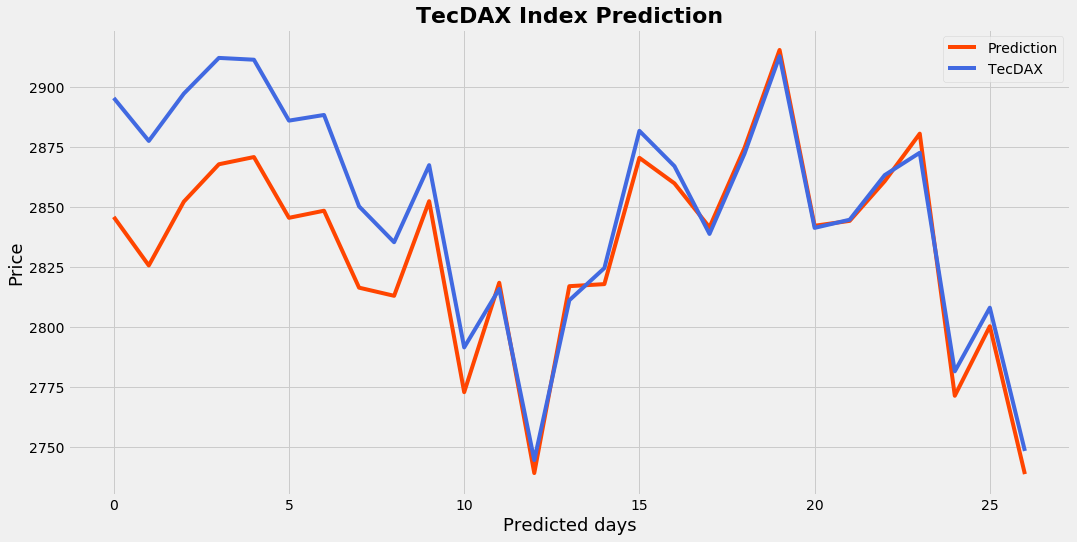

In [37]:
# plotting predicted Index prices against realised Index prices
predicted_level = model.predict(x_test)
plt.rcParams["figure.figsize"] = (16,8)
plt.plot(predicted_level, color = 'orangered', label = 'Prediction')
plt.plot(y_test[0:,], color = 'royalblue', label = 'TecDAX')
plt.title('TecDAX Index Prediction', fontweight='bold',fontsize=22)
plt.xlabel('Predicted days',fontsize=18,color='black')
plt.ylabel('Price',fontsize=18,color='black')
plt.legend()

plt.show()

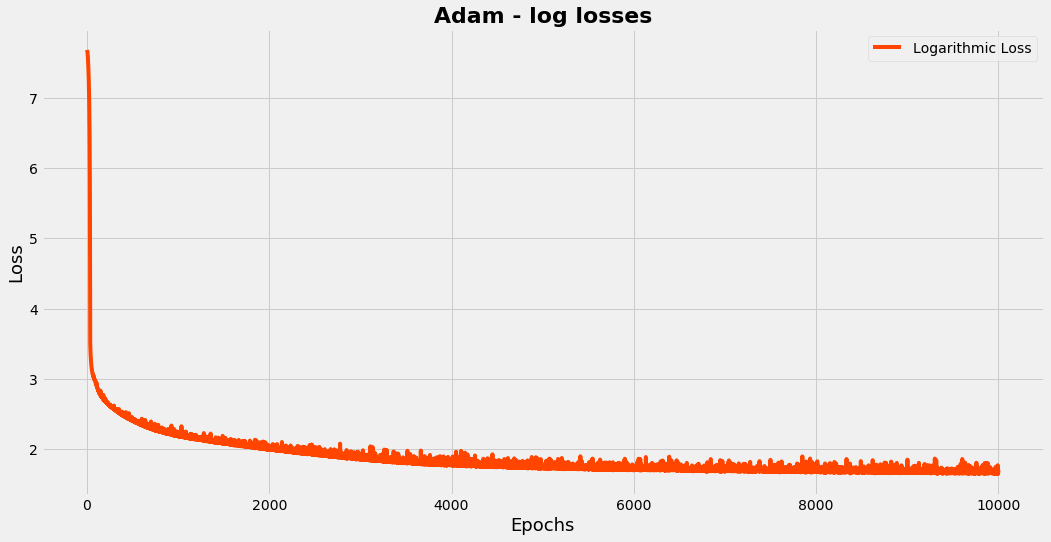

In [38]:
# visualising overfitting
history_dict = history.history
history_dict.keys()
loss_values = np.log(history_dict['val_loss'])
acc = history_dict['val_loss']
epochs = range(1, len(acc) + 1)
plt.rcParams["figure.figsize"] = (16,8)
plt.plot(epochs, loss_values, color = 'orangered', label = 'Logarithmic Loss')
plt.title('Adam - log losses', fontweight='bold',fontsize=22)
plt.xlabel('Epochs',fontsize=18,color='black')
plt.ylabel('Loss',fontsize=18,color='black')
plt.legend()

plt.show()

---
# 3. Additive Model Forecasting
---

In the scope of this report, forecasting is the attempt to predict how future prices will develop. We can distinguish between two major approaches in this matter, namely explanatory and time-series forcasting. While explanatory approaches aim to extract cause and effect relationships between input factors and output factors, time-series forecasting does not concentrate on understanding these relationships reather than finding patterns in past price realisations. There are two reasons for undertaking time-series forcasting. First, the system is too complex to be completely understood or the relationships that affect the output are to difficult to measure. Second, the main concern is not to understand why the output develops in a certain way but how it develops.

Not all forecasting problems can be solved by the same procedure. Prophet is optimized for business forecasting tasks, which have the following characteristics: hourly, daily, or weekly observations with at least a few months (preferably multiple years) of history. At its core, the Prophet procedure is an additive regression model with three main components:

 - A piecewise linear or logistic growth curve trend. Prophet automatically detects changes in trends by selecting changepoints from the data.
 - A yearly seasonal component modeled using Fourier series.
 - A weekly seasonal component using dummy variables.
 
We use the TecDAX Index dataset to train the Prophet Model. However we seperate the observations of the year 2018 and the first half of 2019 into a test set. After training the Prophet Model we predict 1,5 years of the Index Price and compare it to the realised observations in the test set. The prediction results will be shown as a solid blue line with an 80% confidence intervall(light blue area). In orange color we represent the true Index prices realised during the year 2018 and the first half of 2019.

One of the biggest upsides of the Prophet Model is that it does not only predict a possible realisation of a price at a certain time in the future, but also predicts the prices with a 80% confidence intervall. In the context of Stock or Index price realisations, confidence intervalls are an essential feature of forcasting models, since future price realisations are highly uncertain no matter how good the model is. 
 

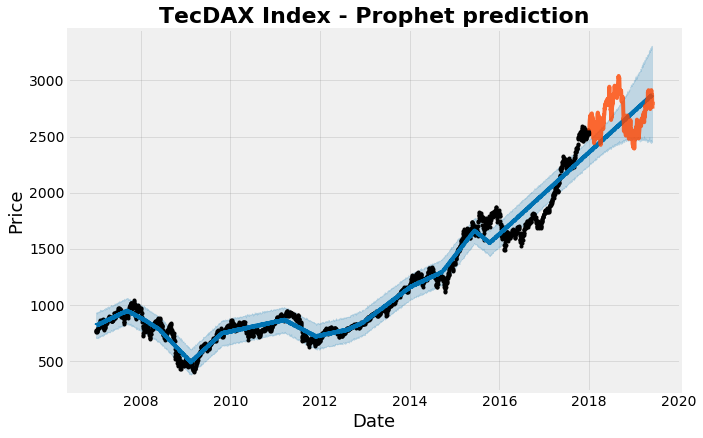

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,self_define_cycle,self_define_cycle_lower,self_define_cycle_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3297,2019-05-24,2866.524379,2455.703798,3285.374903,2463.381531,3282.977951,-1.943778,-1.943778,-1.943778,-1.943778,-1.943778,-1.943778,0.0,0.0,0.0,2864.580601
3298,2019-05-25,2867.520741,2453.174844,3281.925824,2463.437083,3285.816413,-2.194547,-2.194547,-2.194547,-2.194547,-2.194547,-2.194547,0.0,0.0,0.0,2865.326194
3299,2019-05-26,2868.517103,2446.117007,3290.219546,2463.534902,3288.654875,-3.054872,-3.054872,-3.054872,-3.054872,-3.054872,-3.054872,0.0,0.0,0.0,2865.462231
3300,2019-05-27,2869.513465,2465.454991,3302.846664,2463.508045,3291.213592,-3.828502,-3.828502,-3.828502,-3.828502,-3.828502,-3.828502,0.0,0.0,0.0,2865.684963
3301,2019-05-28,2870.509827,2446.775219,3310.775138,2462.523341,3293.531656,-1.224318,-1.224318,-1.224318,-1.224318,-1.224318,-1.224318,0.0,0.0,0.0,2869.285509


In [12]:
#  !! fitting the model can take significant amount of time and computation power !!

# setting up the model specifications
def cycle_analysis(data,split_date,cycle,mode='additive',forecast_plot = False,print_ind=False):
    
    # splitting the data in training and test set
    training = data[:split_date].iloc[:-1,]
    testing = data[split_date:]
    
    # defining the period to predict
    predict_period = len(pd.date_range(split_date,max(data.index)))
    df = training.reset_index()
    df.columns = ['ds','y']
    
    # exchanging default seasionality with self defined cycle
    model = Prophet(weekly_seasonality=False,yearly_seasonality=False,daily_seasonality=False)
    model.add_seasonality('self_define_cycle',period=cycle,fourier_order=8,mode=mode)
    
    # fitting the model
    model.fit(df)
    future = model.make_future_dataframe(periods=predict_period)
    forecast = model.predict(future)
   
    # visualising the results
    if forecast_plot:
        model.plot(forecast)
        plt.plot(testing.index,testing.values,color='orangered',alpha=0.8)
        plt.title("TecDAX Index - Prophet prediction",fontweight='bold',fontsize=22)
        plt.xlabel('Date',fontsize=18,color='black')
        plt.ylabel('Price',fontsize=18,color='black')
        plt.show()
    ret = max(forecast.self_define_cycle)-min(forecast.self_define_cycle)
    model_tb = forecast['yhat']
    model_tb.index = forecast['ds'].map(lambda x:x.strftime("%Y-%m-%d"))
    
    #show model results (last 5 predictions)
    return forecast.tail()
      
# deploying the model to the TecDAX Index data
cycle_analysis(TecDAX_close,'2018-01-02',30,forecast_plot=True,print_ind=True)

---
# 4. Recurrent Neural Network Forecasting
---
Long Short-Term Memory Models (LSTM Models) are recurrent neural networks that are specifically designed to address the vanishing gradient problem. Neural networks weights change according to the partial derivation of the error function with resepect to the current weight in each iteration of training. Traditionally activation functions have gradients in the range of 0 to 1. With backpropagation computing gradients become too small when multiple layers are used. This can prevent training from working effectively.

We train the LSTM Model with the TecDAX Index price data from 01.01.2007 till 30.04.2019. We seperate the price data of May, 2019 in a test set to evaluate the predictions of the model.

In [13]:
# reshaping
TecDAX_close = TecDAX_close.values.reshape(len(TecDAX),1)

# spliting the data into training and test set
train_size = int(len(TecDAX_close) * 0.993)
test_size  = len(TecDAX_close) - train_size
TecDAX_train, TecDAX_test = TecDAX_close[0:train_size,:], TecDAX_close[train_size:len(TecDAX),:]

print("Training observations: ", len(TecDAX_train))
print("Testing observations:  ", len(TecDAX_test))

Training observations:  3120
Testing observations:   23


In [14]:
# normalizing the data
sc = MinMaxScaler(feature_range = (0, 1))

TecDAX_train.shape
training_set_scaled = sc.fit_transform(TecDAX_train)
test_set_scaled     = sc.fit_transform(TecDAX_test)

In [15]:
# creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []

for i in range(60, 1258):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [19]:
# !! fitting the model can take significant amount of time and computation power !!

# initialising the RNN
regressor = Sequential()

# adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# adding the output layer
regressor.add(Dense(units = 1))

# compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
1198/1198 [==============================] - 13s 11ms/step - loss: 0.0037
Epoch 2/100
1198/1198 [==============================] - 10s 8ms/step - loss: 6.5989e-04
Epoch 3/100
1198/1198 [==============================] - 10s 8ms/step - loss: 4.8365e-04
Epoch 4/100
1198/1198 [==============================] - 10s 8ms/step - loss: 4.3539e-04
Epoch 5/100
1198/1198 [==============================] - 10s 8ms/step - loss: 4.1333e-04
Epoch 6/100
1198/1198 [==============================] - 10s 8ms/step - loss: 3.6955e-04
Epoch 7/100
1198/1198 [==============================] - 10s 8ms/step - loss: 3.6678e-04
Epoch 8/100
1198/1198 [==============================] - 10s 8ms/step - loss: 3.2436e-04
Epoch 9/100
1198/1198 [==============================] - 10s 8ms/step - loss: 3.3803e-04
Epoch 10/100
1198/1198 [==============================] - 10s 8ms/step - loss: 3.1953e-04
Epoch 11/100
1198/1198 [==============================] - 10s 8ms/step - loss: 3.1050e-04
Epoch 12/100
1198/1198

1198/1198 [==============================] - 13s 11ms/step - loss: 7.8956e-05
Epoch 92/100
1198/1198 [==============================] - 10s 8ms/step - loss: 7.2711e-05
Epoch 93/100
1198/1198 [==============================] - 14s 12ms/step - loss: 8.3796e-05
Epoch 94/100
1198/1198 [==============================] - 10s 9ms/step - loss: 6.8514e-05
Epoch 95/100
1198/1198 [==============================] - 14s 12ms/step - loss: 7.5327e-05
Epoch 96/100
1198/1198 [==============================] - 15s 12ms/step - loss: 7.6247e-05
Epoch 97/100
1198/1198 [==============================] - 11s 9ms/step - loss: 8.0481e-05
Epoch 98/100
1198/1198 [==============================] - 15s 13ms/step - loss: 9.7568e-05
Epoch 99/100
1198/1198 [==============================] - 11s 9ms/step - loss: 7.9409e-05
Epoch 100/100
1198/1198 [==============================] - 14s 11ms/step - loss: 7.7981e-05


In [20]:
# getting the predicted stock price
dataset_total = pd.concat((pd.Series(TecDAX_train[:,0]),
                           pd.Series(TecDAX_test[:,0])), axis = 0)
inputs = dataset_total[len(dataset_total) - len(TecDAX_test) - 60:]
inputs = inputs.values.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []

for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

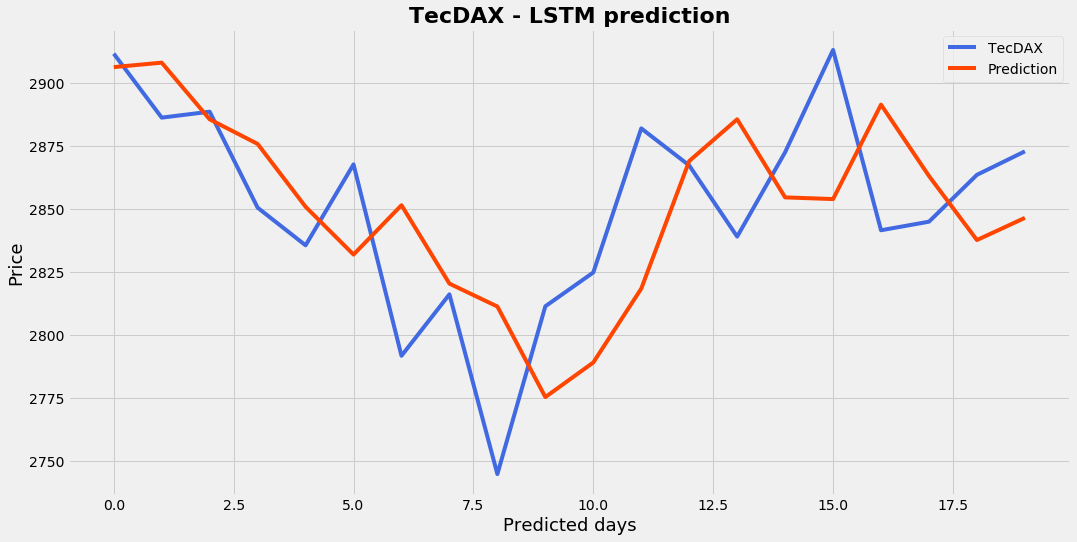

In [21]:
# Visualising the results
plt.rcParams["figure.figsize"] = (16,8)
plt.plot(TecDAX_test[0:20,:], color = 'royalblue', label = 'TecDAX')
plt.plot(predicted_stock_price, color = 'orangered', label = 'Prediction')
plt.title('TecDAX - LSTM prediction', fontweight='bold',fontsize=22)
plt.xlabel('Predicted days',fontsize=18,color='black')
plt.ylabel('Price',fontsize=18,color='black')
plt.legend()

plt.show()

---
**End of Report**. All datasets and code can be found in our GitHub repository:
https://github.com/innovationsteam/Index_Prediction